# medMNIST exploration

In [1]:
import medmnist
print(medmnist.__version__)

3.0.2


In [2]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


### Make a custom sized training dataset

In [19]:
from torch.utils.data import Subset

# Number of positive samples needed
pos_samples = 5

# Get the labels from the dataset (0 for normal, 1 for pneumonia)
labels = train_dataset.labels.flatten()

# Find the indices for the positive (pneumonia) and negative (normal) classes
positive_indices = np.where(labels == 1)[0]
negative_indices = np.where(labels == 0)[0]
num_orig_positive = len(positive_indices)
num_orig_negative = len(negative_indices)
print(f"Original positive samples (pneumonia): {num_orig_positive}")
print(f"Original negative samples (normal): {num_orig_negative}")

# --- Create the new dataset ---

# 1. Randomly sample "pos_samples" indices from the positive class
#    We use replace=False to ensure each selected index is unique.
#    A random seed is used for reproducibility.
np.random.seed(42)
sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)

# 2. Combine the "pos_samples" positive indices with all negative indices
final_indices = np.concatenate([sampled_positive_indices, negative_indices])

# 3. Create the new subset dataset using the combined indices
new_train_dataset = Subset(train_dataset, final_indices)


# --- Verification (Optional) ---
# You can verify the composition of your new dataset

new_labels = labels[final_indices]
num_positive = np.sum(new_labels == 1)
num_negative = np.sum(new_labels == 0)

print(f"Original dataset size: {len(train_dataset)}")
print(f"New dataset size: {len(new_train_dataset)}")
print("-" * 30)
print(f"Samples in new dataset:")
print(f"  - Positive (pneumonia): {num_positive}")
print(f"  - Negative (normal):    {num_negative}")
print(f"  - Total:                {len(new_labels)}")

# You can now use 'new_train_dataset' in your DataLoader
# from torch.utils.data import DataLoader
# train_loader = DataLoader(dataset=new_train_dataset, batch_size=32, shuffle=True)



Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Original dataset size: 4708
New dataset size: 1219
------------------------------
Samples in new dataset:
  - Positive (pneumonia): 5
  - Negative (normal):    1214
  - Total:                1219


In [6]:
print(type(train_dataset[0]))
print(len(train_dataset[0]))
image, label = train_dataset[0]
print(type(image))


<class 'tuple'>
2
<class 'PIL.Image.Image'>


In [7]:
from matplotlib import pyplot as plt

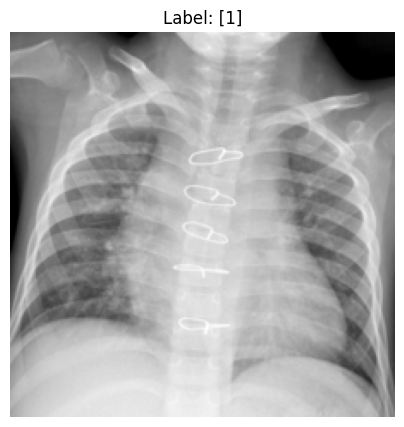

In [8]:
# print 1st 10 samples
for i in range(1):
    image, label = train_dataset[i]
    plt.figure(figsize=(5, 5))
    #image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for plotting
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()

In [9]:
# number of samples of each class
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)
print(f"Number of positive samples: {postive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 3494
Number of negative samples: 1214


In [10]:
info =INFO['pneumoniamnist']
print(info)
n_channels = info['n_channels']
n_classes = info['label']
print("Number of channels:",n_channels)
print("Number of classes",n_classes)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [11]:
dataiter = iter(train_dataset)
image, label = next(dataiter)
print(image.size)
print(label.shape)

(224, 224)
(1,)


### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS



In [12]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 10
NUM_WORKERS = 4

### Create the SequentialNN classifier class

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 224x224 -> 112x112
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 112x112 -> 56x56
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 56x56 -> 28x28
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # Calculate the flattened size dynamically (or pre-calculate)
        # After 4 pooling layers (2x2 stride), the size is 224 / (2^4) = 224 / 16 = 14
        # Flattened size = channels * height * width = 256 * 14 * 14
        self.flattened_size = 256 * 14 * 14

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x) # Output raw logits
        return x


## Lightning Module

In [14]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(in_channels=in_channels, num_classes=num_classes)
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Plot ROC curve

In [15]:
def plot_combined_roc_curves(results_list):
    plt.figure(figsize=(8, 8))
    
    for result in results_list:
        plt.plot(result["fpr"], result["tpr"], lw=2, 
                 label=f'{result["name"]} (area = {result["auc"]:.2f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- Starting Training for 10 epochs on train_loader ---


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_acc

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 37/37 [00:02<00:00, 13.03it/s, v_num=13, train_loss_step=0.0077, train_acc_step=1.000, val_loss=0.0909, val_acc=0.966, val_auc=0.996, train_loss_epoch=0.0329, train_acc_epoch=0.987]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 37/37 [00:02<00:00, 13.00it/s, v_num=13, train_loss_step=0.0077, train_acc_step=1.000, val_loss=0.0909, val_acc=0.966, val_auc=0.996, train_loss_epoch=0.0329, train_acc_epoch=0.987]
Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=02-val_acc=0.97.ckpt
--- Loading best model from Phase 1 for further training ---
--- Reinitializing model for Phase 2 training ---


--- Continuing Training for 10 more epochs on new_train_loader ---


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_acc

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s, v_num=14, train_loss_step=2.99e-6, train_acc_step=1.000, val_loss=13.60, val_acc=0.422, val_auc=0.805, train_loss_epoch=0.000769, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s, v_num=14, train_loss_step=2.99e-6, train_acc_step=1.000, val_loss=13.60, val_acc=0.422, val_auc=0.805, train_loss_epoch=0.000769, train_acc_epoch=1.000]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=02-val_acc=0.97.ckpt


Best model from Phase 2 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.42.ckpt

--- All training complete. Starting evaluation phase. ---

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=02-val_acc=0.97.ckpt ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:282: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val_acc', 'mode': 'max', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=02-val_acc=0.97.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 16.90it/s]
--- Final Test Metrics ---
Accuracy: 0.8205
AUC: 0.9429
Precision: 0.7814
Recall: 0.9897
F1-Score: 0.8733
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 13.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8205128312110901
     test_auc_epoch         0.9429104328155518
        test_loss           0.5585517883300781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.42.ckpt



--- Testing model from final checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.42.ckpt ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.42.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 50.76it/s]
--- Final Test Metrics ---
Accuracy: 0.5417
AUC: 0.8822
Precision: 0.9815
Recall: 0.2718
F1-Score: 0.4257
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 44.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.5416666865348816
     test_auc_epoch         0.8822047114372253
        test_loss            9.802685737609863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Generating Combined ROC Curve Plot ---


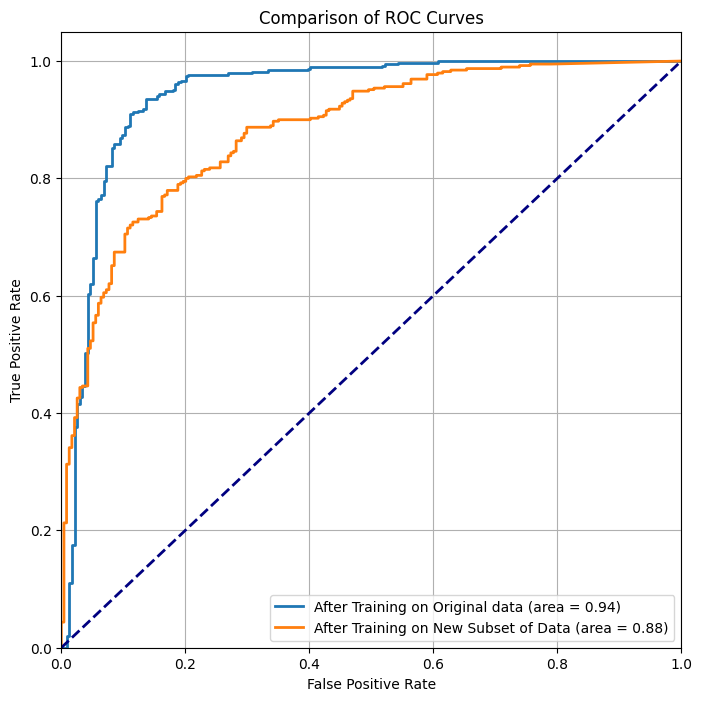

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar


# --- Main Execution Block ---
if __name__ == '__main__':
    # Ensure you have your train_loader and val_loader defined here
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dataset.transform = data_transforms
    test_dataset.transform = data_transforms
    val_dataset.transform = data_transforms


    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # 1. Instantiate the LightningModule
    model = LitSimpleCNN(
        in_channels=NUM_CHANNELS,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE
    )
    
    # Optional: Print model summary
    # You need to move the model to a device first for torchsummary to work
    # summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
    # model.to('cpu') # Move it back if needed

    # 2. Define Callbacks
    # Save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        dirpath='checkpoints/',
        filename='simple-cnn-{epoch:02d}-{val_acc:.2f}',
        save_top_k=1,
        mode='max',
    )
    
    # A cleaner progress bar
    progress_bar = TQDMProgressBar(refresh_rate=10)

    # 3. Instantiate the Trainer for Multi-GPU Training
    train_trainer_1 = pl.Trainer(
        accelerator='gpu',                 # Use GPUs
        devices=2,                         # Number of GPUs to use
        strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
        max_epochs=NUM_EPOCHS,              # Total number of epochs
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn"),
        # Optimization for your 2080Ti's Tensor Cores
        precision='16-mixed'
    )

    train_trainer_2 = pl.Trainer(
        accelerator='gpu',                 # Use GPUs
        devices=2,                         # Number of GPUs to use
        strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
        max_epochs=NUM_EPOCHS,              # Total number of epochs
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn"),
        # Optimization for your 2080Ti's Tensor Cores
        precision='16-mixed'
    )
    # Create a separate Trainer for testing

    test_trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,  # Use only one GPU
        logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
        # Add the callback here so the Trainer can find the 'best' path
        callbacks=[checkpoint_callback] 
    )


        # ===================================================================
    # --- STEP 1: All TRAINING HAPPENS FIRST ---
    # ===================================================================

    # --- Phase 1 Training ---
    print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
    train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    # CRITICAL: Save the path to the best model from this phase
    path_after_phase1 = checkpoint_callback.best_model_path
    print(f"Best model from Phase 1 saved to: {path_after_phase1}")

    # Load the best model from Phase 1 to continue training
    print(f"--- Loading best model from Phase 1 for further training ---")
    #model = LitSimpleCNN.load_from_checkpoint(path_after_phase1) 

    # Reinitialize the model with the same hyperparameters to forget the previous state
    # This is optional, but ensures we start fresh for Phase 2
    # If you want to continue training with the same model, you can skip this step
    print(f"--- Reinitializing model for Phase 2 training ---")
    model = LitSimpleCNN(
        in_channels=NUM_CHANNELS,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE
    )

    # --- Phase 2 Training ---
    print(f"\n\n--- Continuing Training for {NUM_EPOCHS} more epochs on new_train_loader ---")
    
    train_trainer_2.fit(model, train_dataloaders=new_train_loader, val_dataloaders=val_loader)
    
    # CRITICAL: Save the path to the final best model
    path_after_phase2 = checkpoint_callback.best_model_path
    print(f"Best model from Phase 2 saved to: {path_after_phase2}")


    # ===================================================================
    # --- STEP 2: All TESTING HAPPENS AT THE END ---
    # ===================================================================
    print("\n--- All training complete. Starting evaluation phase. ---")
    
    # Instantiate a single-GPU trainer for testing
    test_trainer = pl.Trainer(accelerator='gpu', devices=1)

    # --- Test 1: Evaluate the model from after Phase 1 ---
    print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
    model.current_test_title = "ROC Curve after training on DataLoader 1"
    test_trainer.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
    results_phase1 = model.last_test_results.copy()
    results_phase1["name"] = "After Training on Original data"

    # --- Test 2: Evaluate the final model from after Phase 2 ---
    print(f"\n--- Testing model from final checkpoint: {path_after_phase2} ---")
    model.current_test_title = "ROC Curve after fine-tuning"
    test_trainer.test(model, dataloaders=test_loader, ckpt_path=path_after_phase2)
    results_phase2 = model.last_test_results.copy()
    results_phase2["name"] = "After Training on New Subset of Data"

    # ===================================================================
    # --- FINAL STEP: Plot the combined ROC curves ---
    # ===================================================================
    print("\n--- Generating Combined ROC Curve Plot ---")
    plot_combined_roc_curves([results_phase1, results_phase2])

### Analysis of the flattened output (Fully connected network before classification)
* Perform forward pass on 3 positive and 3 negative samples
* Visualise the fully connected layer output for the 6 samples

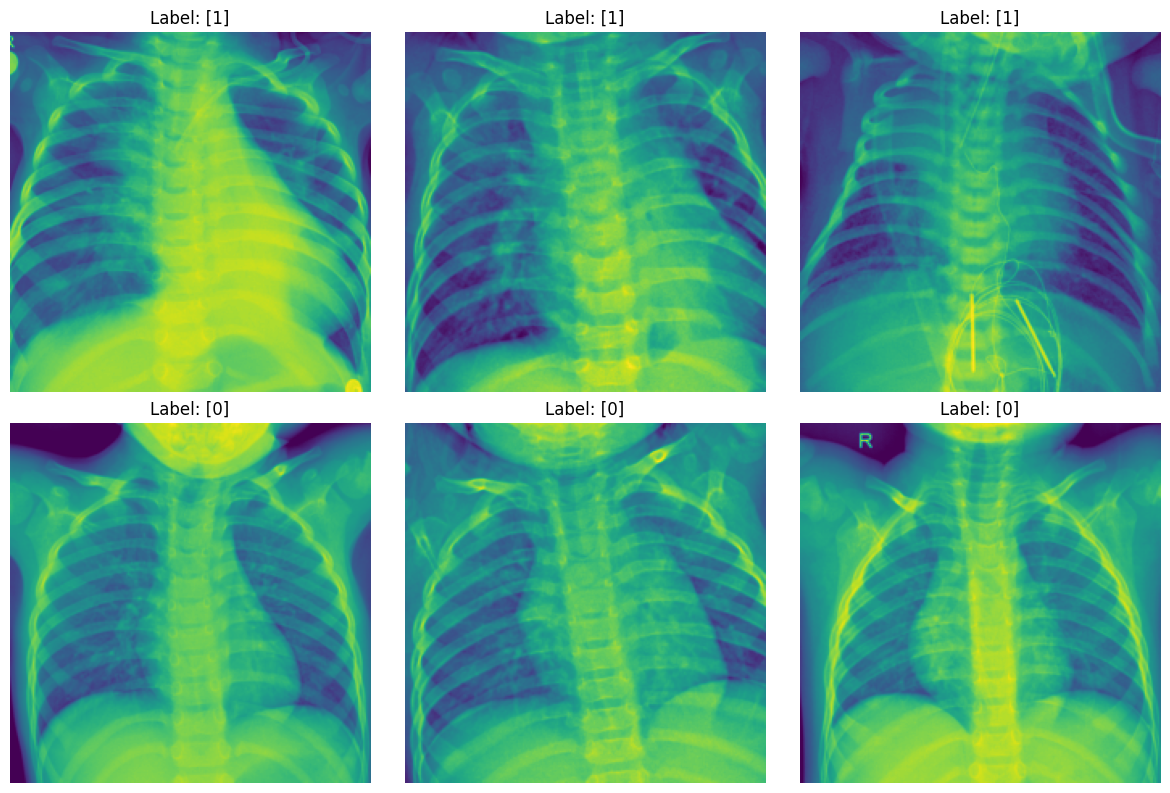

In [17]:
# select 3 positive labels and 3 negative labels from test dataset
positive_samples = [i for i, (_, label) in enumerate(train_dataset) if label == 1]
negative_samples = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
selected_positive_samples = np.random.choice(positive_samples, 3, replace=False)
selected_negative_samples = np.random.choice(negative_samples, 3, replace=False)
# Combine selected samples
selected_samples = np.concatenate((selected_positive_samples, selected_negative_samples))
# Plot the selected samples
plt.figure(figsize=(12, 8))
for i, idx in enumerate(selected_samples):
    image, label = train_dataset[idx]
    plt.subplot(2, 3, i + 1)
    image = image.permute(1,2,0)
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
plt.tight_layout()
plt.show()

* Perform a forward pass on these samples and plot the output at each layer

In [18]:
model_orig.eval() # Set model to evaluation mode

# Dictionary to store the activations
activations = {}
# List to store hook handles
hook_handles = []

def get_activation(name):
    def hook(model, input, output):
        # Store the output tensor, detaching it from the graph and moving to CPU
        activations[name] = output.detach().cpu()
    return hook

# Define the layers you want to hook into
# These are the nn.Sequential blocks in your SimpleCNN
layers_to_hook = {
    'Layer 1 (Conv1-ReLU-Pool1)': model_orig.layer1,
    'Layer 2 (Conv2-ReLU-Pool2)': model_orig.layer2,
    'Layer 3 (Conv3-ReLU-Pool3)': model_orig.layer3,
    'Layer 4 (Conv4-ReLU-Pool4)': model_orig.layer4,
    'FC1 Output (raw)': model_orig.fc1,             # Output of the nn.Linear module
    'FC1 Output (after ReLU)': model_orig.relu_fc,  # Output of the nn.ReLU module
    'FC2 Output (Logits)': model_orig.fc2           # Output of the final nn.Linear module
}

num_selected_images = len(selected_samples)
num_total_layers_to_plot = len(layers_to_hook)

# Create a figure for plotting.
fig, axes = plt.subplots(num_selected_images, num_total_layers_to_plot + 1, # +1 for original image
                         figsize=((num_total_layers_to_plot + 1) * 3.5, num_selected_images * 4.0), # Increased height a bit
                         squeeze=False)

print(f"Visualizing feature maps and FC outputs for {num_selected_images} selected samples.")

for i, sample_idx in enumerate(selected_samples):
    img_tensor, label = train_dataset[sample_idx]
    img_tensor = img_tensor.to(device)

    if img_tensor.ndim == 3:
        img_batch = img_tensor.unsqueeze(0)
    elif img_tensor.ndim == 4 and img_tensor.shape[0] == 1:
        img_batch = img_tensor
    else:
        print(f"Warning: Image tensor for sample {sample_idx} has unexpected shape {img_tensor.shape}. Skipping.")
        axes[i, 0].set_title(f"Sample {sample_idx}\nSkipped (Shape Error)")
        axes[i, 0].axis('off')
        for j_layer in range(num_total_layers_to_plot):
             axes[i, j_layer + 1].set_title("Skipped")
             axes[i, j_layer + 1].axis('off')
        continue

    activations.clear()
    for handle in hook_handles:
        handle.remove()
    hook_handles.clear()

    for name, layer_module in layers_to_hook.items():
        hook_handles.append(layer_module.register_forward_hook(get_activation(name)))

    with torch.no_grad():
        _ = model_orig(img_batch)

    # --- Plot original image ---
    ax_orig = axes[i, 0]
    img_to_plot_orig = img_tensor.cpu()
    if img_to_plot_orig.shape[0] > 0: # Get the first channel if multi-channel
        img_to_plot_orig = img_to_plot_orig[0, :, :]
    img_to_plot_orig = img_to_plot_orig.numpy()
    ax_orig.imshow(img_to_plot_orig, cmap='gray')
    ax_orig.set_title(f"Sample Idx: {sample_idx}\nOriginal (Label: {label})")
    ax_orig.axis('off')

    # --- Plot feature maps and FC outputs ---
    plot_col_idx = 1
    for layer_name, _ in layers_to_hook.items(): # Iterate in defined order
        ax_feat = axes[i, plot_col_idx]
        if layer_name in activations:
            current_activation = activations[layer_name]
            # For Conv layers, output is [batch_size, channels, H, W]
            # For FC layers, output is [batch_size, num_features]
            
            if 'FC' in layer_name: # Handle FC layers
                fc_output = current_activation[0, :].numpy() # Shape [num_features]
                if fc_output.ndim == 0: fc_output = np.array([fc_output]) # Ensure it's an array

                num_features = len(fc_output)
                
                if "FC1" in layer_name: # For fc1 or relu_fc output (e.g., 512 features)
                    if num_features == 0:
                        ax_feat.text(0.5, 0.5, "No features", horizontalalignment='center', verticalalignment='center', transform=ax_feat.transAxes)
                    else:
                        # Reshape to a 2D array for heatmap visualization
                        h_dim = int(np.sqrt(num_features))
                        if h_dim == 0: h_dim = 1 
                        w_dim = (num_features + h_dim - 1) // h_dim # Ceiling division
                        
                        # Pad with mean of features to make it rectangular
                        pad_value = np.mean(fc_output) if num_features > 0 else 0
                        padded_features = np.pad(fc_output, (0, h_dim * w_dim - num_features), 'constant', constant_values=pad_value)
                        feature_map_fc = padded_features.reshape((h_dim, w_dim))
                        
                        im = ax_feat.imshow(feature_map_fc, cmap='viridis', aspect='auto')
                        # fig.colorbar(im, ax=ax_feat, fraction=0.046, pad=0.04) # Optional colorbar
                    ax_feat.set_title(f"{layer_name}\n({num_features} units)")

                elif "FC2" in layer_name: # For fc2 output (logits)
                    if num_features == 1:
                        ax_feat.text(0.5, 0.4, f"Logit:\n{fc_output[0]:.3f}",
                                     horizontalalignment='center', verticalalignment='center',
                                     fontsize=10, transform=ax_feat.transAxes)
                        # Optionally, show sigmoid output if it's binary classification logit
                        sigmoid_val = 1 / (1 + np.exp(-fc_output[0]))
                        ax_feat.text(0.5, 0.6, f"Sigmoid:\n{sigmoid_val:.3f}",
                                     horizontalalignment='center', verticalalignment='center',
                                     fontsize=10, transform=ax_feat.transAxes)

                    else: # Multiple logits
                        ax_feat.bar(range(num_features), fc_output)
                        ax_feat.set_xticks(range(num_features))
                        # Optional: show softmax output
                        # exp_vals = np.exp(fc_output - np.max(fc_output)) # Subtract max for numerical stability
                        # softmax_vals = exp_vals / np.sum(exp_vals)
                        # for k_logit, val in enumerate(softmax_vals):
                        #     ax_feat.text(k_logit, fc_output[k_logit] / 2, f"{val:.2f}", ha='center', va='center', color='white', fontsize=8)

                    ax_feat.set_title(f"{layer_name}\n({num_features} logits)")

            else: # Convolutional layer output (1st channel)
                feature_map_conv = current_activation[0, 0, :, :].numpy()
                if feature_map_conv.shape[0] <= 1 and feature_map_conv.shape[1] <= 1:
                     ax_feat.imshow(feature_map_conv, cmap='viridis', aspect='auto', interpolation='nearest')
                     ax_feat.set_xticks([])
                     ax_feat.set_yticks([])
                else:
                    ax_feat.imshow(feature_map_conv, cmap='viridis', aspect='auto')
                ax_feat.set_title(f"{layer_name}\n(1st Channel Output)")
        else:
            ax_feat.set_title(f"{layer_name}\n(Not captured)")
        ax_feat.axis('off')
        plot_col_idx += 1

# Clean up hooks
for handle in hook_handles:
    handle.remove()

plt.tight_layout(pad=0.5, h_pad=2.0, w_pad=0.5) # Adjusted h_pad for more space between rows
plt.suptitle("Feature Maps & FC Outputs Visualization", fontsize=16, y=1.02) # Adjusted y for suptitle
plt.show()

NameError: name 'model_orig' is not defined

## Cost sensitive learning implementation

* Create a variable that will give the number of classifiers
* Weights are between 0.001 to 0.999
* calculate pos_weight to be used with the BCE loss function

In [ ]:
NUM_CLASSIFIERS = 500
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)


* loop throught the pos_weights and train NUM_CLASSIFIER classifiers

In [ ]:
from sklearn.metrics import confusion_matrix

fpr_weighted = []
tpr_weighted = []

model = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)

for i, pos_weight in enumerate(pos_weights):
    print(f"Positive weight: {pos_weight:.3f}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    # Load pretrained weights into the current model
    if i > 0:  # Load weights from previous iteration only after the first iteration
        try:
            model.load_state_dict(torch.load(f'weights/model_weights_{i-1}.pth'))
            print("Model weights loaded successfully.")
        except FileNotFoundError:
            print("Error: Weights file not found.  Continuing with current weights.")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train and validate the model
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
        val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

    torch.save(model.state_dict(), f'weights/model_weights_{i}.pth')
    print(f"Model {i} weights saved successfully.")
   # Manual Inference and Metric Calculation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"[Test - pos_weight={pos_weight:.3f}]", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float() #Binary predictions
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    #Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    test_recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else float('nan')
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    #Calculate FPR and TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')

    fpr_weighted.append(fpr)
    tpr_weighted.append(tpr)

np.save('fpr_weighted_NN_pneumonia.npy', fpr_weighted)
np.save('tpr_weighted_NN_pneumonia.npy', tpr_weighted)



Positive weight: 0.001


Epoch 1 Train Loss: 0.0079 Acc: 0.3144


         Validation Loss: 0.0037 Acc: 0.2576 AUC: 0.9608
Model 0 weights saved successfully.


Test Accuracy: 0.3750
Test Precision: nan
Test Recall: 0.0000
Test F1-Score: nan
Positive weight: 0.003
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0060 Acc: 0.5888


         Validation Loss: 0.0043 Acc: 0.6527 AUC: 0.9861
Model 1 weights saved successfully.


Test Accuracy: 0.7131
Test Precision: 0.9607
Test Recall: 0.5641
Test F1-Score: 0.7108
Positive weight: 0.005
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0080 Acc: 0.7273


         Validation Loss: 0.0102 Acc: 0.7538 AUC: 0.9830
Model 2 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.9500
Test Recall: 0.7308
Test F1-Score: 0.8261
Positive weight: 0.007
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0085 Acc: 0.7774


         Validation Loss: 0.0134 Acc: 0.5305 AUC: 0.9923
Model 3 weights saved successfully.


Test Accuracy: 0.6250
Test Precision: 0.9643
Test Recall: 0.4154
Test F1-Score: 0.5806
Positive weight: 0.009
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0103 Acc: 0.7982


         Validation Loss: 0.0122 Acc: 0.6431 AUC: 0.9944
Model 4 weights saved successfully.


Test Accuracy: 0.7340
Test Precision: 0.9667
Test Recall: 0.5949
Test F1-Score: 0.7365
Positive weight: 0.011
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0095 Acc: 0.8452


         Validation Loss: 0.0089 Acc: 0.8378 AUC: 0.9899
Model 5 weights saved successfully.


Test Accuracy: 0.8702
Test Precision: 0.9452
Test Recall: 0.8410
Test F1-Score: 0.8901
Positive weight: 0.013
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0099 Acc: 0.8456


         Validation Loss: 0.0088 Acc: 0.7939 AUC: 0.9932
Model 6 weights saved successfully.


Test Accuracy: 0.8478
Test Precision: 0.9275
Test Recall: 0.8205
Test F1-Score: 0.8707
Positive weight: 0.015
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0083 Acc: 0.8980


         Validation Loss: 0.0193 Acc: 0.7042 AUC: 0.9952
Model 7 weights saved successfully.


Test Accuracy: 0.7965
Test Precision: 0.9550
Test Recall: 0.7077
Test F1-Score: 0.8130
Positive weight: 0.017
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0103 Acc: 0.8983


         Validation Loss: 0.0142 Acc: 0.9275 AUC: 0.9930
Model 8 weights saved successfully.


Test Accuracy: 0.9087
Test Precision: 0.9051
Test Recall: 0.9538
Test F1-Score: 0.9288
Positive weight: 0.019
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0090 Acc: 0.9099


         Validation Loss: 0.0120 Acc: 0.8912 AUC: 0.9936
Model 9 weights saved successfully.


Test Accuracy: 0.8814
Test Precision: 0.9093
Test Recall: 0.9000
Test F1-Score: 0.9046
Positive weight: 0.021
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0106 Acc: 0.9163


         Validation Loss: 0.0107 Acc: 0.8397 AUC: 0.9956
Model 10 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.9098
Test Recall: 0.8538
Test F1-Score: 0.8810
Positive weight: 0.024
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0072 Acc: 0.9407


         Validation Loss: 0.0075 Acc: 0.9275 AUC: 0.9961
Model 11 weights saved successfully.


Test Accuracy: 0.8926
Test Precision: 0.8929
Test Recall: 0.9410
Test F1-Score: 0.9164
Positive weight: 0.026
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0078 Acc: 0.9373


         Validation Loss: 0.0122 Acc: 0.9561 AUC: 0.9959
Model 12 weights saved successfully.


Test Accuracy: 0.8990
Test Precision: 0.8707
Test Recall: 0.9846
Test F1-Score: 0.9242
Positive weight: 0.028
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0090 Acc: 0.9437


         Validation Loss: 0.0180 Acc: 0.8206 AUC: 0.9945
Model 13 weights saved successfully.


Test Accuracy: 0.8510
Test Precision: 0.9255
Test Recall: 0.8282
Test F1-Score: 0.8742
Positive weight: 0.030
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0088 Acc: 0.9454


         Validation Loss: 0.0126 Acc: 0.9427 AUC: 0.9948
Model 14 weights saved successfully.


Test Accuracy: 0.9119
Test Precision: 0.9056
Test Recall: 0.9590
Test F1-Score: 0.9315
Positive weight: 0.032
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0063 Acc: 0.9616


         Validation Loss: 0.0144 Acc: 0.9389 AUC: 0.9936
Model 15 weights saved successfully.


Test Accuracy: 0.8926
Test Precision: 0.8873
Test Recall: 0.9487
Test F1-Score: 0.9170
Positive weight: 0.034
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0090 Acc: 0.9571


         Validation Loss: 0.0144 Acc: 0.9027 AUC: 0.9952
Model 16 weights saved successfully.


Test Accuracy: 0.9087
Test Precision: 0.9215
Test Recall: 0.9333
Test F1-Score: 0.9274
Positive weight: 0.036
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0077 Acc: 0.9639


         Validation Loss: 0.0122 Acc: 0.9408 AUC: 0.9959
Model 17 weights saved successfully.


Test Accuracy: 0.9022
Test Precision: 0.8964
Test Recall: 0.9538
Test F1-Score: 0.9242
Positive weight: 0.038
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0063 Acc: 0.9675


         Validation Loss: 0.0085 Acc: 0.9561 AUC: 0.9977
Model 18 weights saved successfully.


Test Accuracy: 0.8990
Test Precision: 0.8759
Test Recall: 0.9769
Test F1-Score: 0.9236
Positive weight: 0.041
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0059 Acc: 0.9715


         Validation Loss: 0.0131 Acc: 0.9656 AUC: 0.9968
Model 19 weights saved successfully.


Test Accuracy: 0.8830
Test Precision: 0.8610
Test Recall: 0.9692
Test F1-Score: 0.9119
Positive weight: 0.043
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0080 Acc: 0.9679


         Validation Loss: 0.0182 Acc: 0.9218 AUC: 0.9966
Model 20 weights saved successfully.


Test Accuracy: 0.9103
Test Precision: 0.9282
Test Recall: 0.9282
Test F1-Score: 0.9282
Positive weight: 0.045
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0082 Acc: 0.9828


         Validation Loss: 0.0120 Acc: 0.9561 AUC: 0.9973
Model 21 weights saved successfully.


Test Accuracy: 0.9103
Test Precision: 0.9053
Test Recall: 0.9564
Test F1-Score: 0.9302
Positive weight: 0.047
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0067 Acc: 0.9764


         Validation Loss: 0.0165 Acc: 0.9218 AUC: 0.9967
Model 22 weights saved successfully.


Test Accuracy: 0.8894
Test Precision: 0.8943
Test Recall: 0.9333
Test F1-Score: 0.9134
Positive weight: 0.049
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0082 Acc: 0.9698


         Validation Loss: 0.0159 Acc: 0.9695 AUC: 0.9962
Model 23 weights saved successfully.


Test Accuracy: 0.8750
Test Precision: 0.8467
Test Recall: 0.9769
Test F1-Score: 0.9071
Positive weight: 0.052
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0049 Acc: 0.9843


         Validation Loss: 0.0300 Acc: 0.9656 AUC: 0.9936
Model 24 weights saved successfully.


Test Accuracy: 0.8622
Test Precision: 0.8304
Test Recall: 0.9795
Test F1-Score: 0.8988
Positive weight: 0.054
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0039 Acc: 0.9873


         Validation Loss: 0.0155 Acc: 0.9599 AUC: 0.9968
Model 25 weights saved successfully.


Test Accuracy: 0.8942
Test Precision: 0.8785
Test Recall: 0.9641
Test F1-Score: 0.9193
Positive weight: 0.056
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0042 Acc: 0.9877


         Validation Loss: 0.0412 Acc: 0.9752 AUC: 0.9932
Model 26 weights saved successfully.


Test Accuracy: 0.8429
Test Precision: 0.8106
Test Recall: 0.9769
Test F1-Score: 0.8860
Positive weight: 0.058
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0082 Acc: 0.9851


         Validation Loss: 0.0169 Acc: 0.9618 AUC: 0.9968
Model 27 weights saved successfully.


Test Accuracy: 0.9038
Test Precision: 0.8873
Test Recall: 0.9692
Test F1-Score: 0.9265
Positive weight: 0.060
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0040 Acc: 0.9917


         Validation Loss: 0.0157 Acc: 0.9714 AUC: 0.9977
Model 28 weights saved successfully.


Test Accuracy: 0.8766
Test Precision: 0.8455
Test Recall: 0.9821
Test F1-Score: 0.9087
Positive weight: 0.063
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0053 Acc: 0.9890


         Validation Loss: 0.0264 Acc: 0.9733 AUC: 0.9960
Model 29 weights saved successfully.


Test Accuracy: 0.8750
Test Precision: 0.8436
Test Recall: 0.9821
Test F1-Score: 0.9076
Positive weight: 0.065
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0047 Acc: 0.9887


         Validation Loss: 0.0211 Acc: 0.9523 AUC: 0.9965
Model 30 weights saved successfully.


Test Accuracy: 0.8974
Test Precision: 0.8791
Test Recall: 0.9692
Test F1-Score: 0.9220
Positive weight: 0.067
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0043 Acc: 0.9915


         Validation Loss: 0.0648 Acc: 0.9408 AUC: 0.9871
Model 31 weights saved successfully.


Test Accuracy: 0.8782
Test Precision: 0.8618
Test Recall: 0.9590
Test F1-Score: 0.9078
Positive weight: 0.070
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0026 Acc: 0.9936


         Validation Loss: 0.0554 Acc: 0.9752 AUC: 0.9971
Model 32 weights saved successfully.


Test Accuracy: 0.8269
Test Precision: 0.7866
Test Recall: 0.9923
Test F1-Score: 0.8776
Positive weight: 0.072
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0031 Acc: 0.9955


         Validation Loss: 0.0594 Acc: 0.9847 AUC: 0.9918
Model 33 weights saved successfully.


Test Accuracy: 0.8285
Test Precision: 0.7894
Test Recall: 0.9897
Test F1-Score: 0.8783
Positive weight: 0.074
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0064 Acc: 0.9928


         Validation Loss: 0.0934 Acc: 0.9656 AUC: 0.9916
Model 34 weights saved successfully.


Test Accuracy: 0.8333
Test Precision: 0.7918
Test Recall: 0.9949
Test F1-Score: 0.8818
Positive weight: 0.076
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0035 Acc: 0.9907


         Validation Loss: 0.0549 Acc: 0.9695 AUC: 0.9958
Model 35 weights saved successfully.


Test Accuracy: 0.8333
Test Precision: 0.7930
Test Recall: 0.9923
Test F1-Score: 0.8815
Positive weight: 0.079
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0077 Acc: 0.9890


         Validation Loss: 0.0955 Acc: 0.9695 AUC: 0.9924
Model 36 weights saved successfully.


Test Accuracy: 0.8221
Test Precision: 0.7796
Test Recall: 0.9974
Test F1-Score: 0.8751
Positive weight: 0.081
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0139 Acc: 0.9841


         Validation Loss: 0.0216 Acc: 0.9714 AUC: 0.9957
Model 37 weights saved successfully.


Test Accuracy: 0.8446
Test Precision: 0.8058
Test Recall: 0.9897
Test F1-Score: 0.8884
Positive weight: 0.083
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0054 Acc: 0.9904


         Validation Loss: 0.0310 Acc: 0.9733 AUC: 0.9963
Model 38 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.8151
Test Recall: 0.9949
Test F1-Score: 0.8961
Positive weight: 0.086
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0048 Acc: 0.9904


         Validation Loss: 0.0899 Acc: 0.9427 AUC: 0.9831
Model 39 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.8261
Test Recall: 0.9744
Test F1-Score: 0.8941
Positive weight: 0.088
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0068 Acc: 0.9919


         Validation Loss: 0.1778 Acc: 0.9580 AUC: 0.9763
Model 40 weights saved successfully.


Test Accuracy: 0.7981
Test Precision: 0.7588
Test Recall: 0.9923
Test F1-Score: 0.8600
Positive weight: 0.091
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0127 Acc: 0.9911


         Validation Loss: 0.0459 Acc: 0.9599 AUC: 0.9958
Model 41 weights saved successfully.


Test Accuracy: 0.8638
Test Precision: 0.8381
Test Recall: 0.9692
Test F1-Score: 0.8989
Positive weight: 0.093
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0065 Acc: 0.9968


         Validation Loss: 0.1087 Acc: 0.9733 AUC: 0.9913
Model 42 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7823
Test Recall: 0.9949
Test F1-Score: 0.8758
Positive weight: 0.095
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0097 Acc: 0.9932


         Validation Loss: 0.0628 Acc: 0.9695 AUC: 0.9920
Model 43 weights saved successfully.


Test Accuracy: 0.8381
Test Precision: 0.7967
Test Recall: 0.9949
Test F1-Score: 0.8848
Positive weight: 0.098
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0053 Acc: 0.9941


         Validation Loss: 0.0931 Acc: 0.9695 AUC: 0.9929
Model 44 weights saved successfully.


Test Accuracy: 0.8526
Test Precision: 0.8143
Test Recall: 0.9897
Test F1-Score: 0.8935
Positive weight: 0.100
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0153 Acc: 0.9862


         Validation Loss: 0.0417 Acc: 0.9637 AUC: 0.9958
Model 45 weights saved successfully.


Test Accuracy: 0.8429
Test Precision: 0.8160
Test Recall: 0.9667
Test F1-Score: 0.8850
Positive weight: 0.103
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0061 Acc: 0.9964


         Validation Loss: 0.0746 Acc: 0.9714 AUC: 0.9945
Model 46 weights saved successfully.


Test Accuracy: 0.8349
Test Precision: 0.7971
Test Recall: 0.9872
Test F1-Score: 0.8820
Positive weight: 0.105
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0109 Acc: 0.9917


         Validation Loss: 0.0395 Acc: 0.9676 AUC: 0.9961
Model 47 weights saved successfully.


Test Accuracy: 0.8846
Test Precision: 0.8518
Test Recall: 0.9872
Test F1-Score: 0.9145
Positive weight: 0.107
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0072 Acc: 0.9934


         Validation Loss: 0.0491 Acc: 0.9695 AUC: 0.9967
Model 48 weights saved successfully.


Test Accuracy: 0.8494
Test Precision: 0.8109
Test Recall: 0.9897
Test F1-Score: 0.8915
Positive weight: 0.110
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0059 Acc: 0.9921


         Validation Loss: 0.1536 Acc: 0.9656 AUC: 0.9915
Model 49 weights saved successfully.


Test Accuracy: 0.8061
Test Precision: 0.7653
Test Recall: 0.9949
Test F1-Score: 0.8651
Positive weight: 0.112
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0045 Acc: 0.9972


         Validation Loss: 0.0610 Acc: 0.9542 AUC: 0.9941
Model 50 weights saved successfully.


Test Accuracy: 0.8718
Test Precision: 0.8384
Test Recall: 0.9846
Test F1-Score: 0.9057
Positive weight: 0.115
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0055 Acc: 0.9955


         Validation Loss: 0.1255 Acc: 0.9656 AUC: 0.9882
Model 51 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.8205
Test Recall: 0.9846
Test F1-Score: 0.8951
Positive weight: 0.117
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0030 Acc: 0.9966


         Validation Loss: 0.1135 Acc: 0.9618 AUC: 0.9894
Model 52 weights saved successfully.


Test Accuracy: 0.8782
Test Precision: 0.8458
Test Recall: 0.9846
Test F1-Score: 0.9100
Positive weight: 0.120
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0126 Acc: 0.9955


         Validation Loss: 0.0833 Acc: 0.9752 AUC: 0.9951
Model 53 weights saved successfully.


Test Accuracy: 0.8253
Test Precision: 0.7838
Test Recall: 0.9949
Test F1-Score: 0.8768
Positive weight: 0.122
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0012 Acc: 0.9981


         Validation Loss: 0.1071 Acc: 0.9733 AUC: 0.9961
Model 54 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7914
Test Recall: 0.9923
Test F1-Score: 0.8805
Positive weight: 0.125
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 0.1363 Acc: 0.9752 AUC: 0.9957
Model 55 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7902
Test Recall: 0.9949
Test F1-Score: 0.8808
Positive weight: 0.127
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0138 Acc: 0.9932


         Validation Loss: 0.0743 Acc: 0.9752 AUC: 0.9927
Model 56 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.8165
Test Recall: 0.9923
Test F1-Score: 0.8958
Positive weight: 0.130
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0096 Acc: 0.9934


         Validation Loss: 0.1112 Acc: 0.9752 AUC: 0.9923
Model 57 weights saved successfully.


Test Accuracy: 0.8029
Test Precision: 0.7644
Test Recall: 0.9897
Test F1-Score: 0.8626
Positive weight: 0.133
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0072 Acc: 0.9955


         Validation Loss: 0.0914 Acc: 0.9695 AUC: 0.9931
Model 58 weights saved successfully.


Test Accuracy: 0.8670
Test Precision: 0.8315
Test Recall: 0.9872
Test F1-Score: 0.9027
Positive weight: 0.135
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0120 Acc: 0.9945


         Validation Loss: 0.0572 Acc: 0.9733 AUC: 0.9962
Model 59 weights saved successfully.


Test Accuracy: 0.8446
Test Precision: 0.8046
Test Recall: 0.9923
Test F1-Score: 0.8886
Positive weight: 0.138
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0321 Acc: 0.9960


         Validation Loss: 0.0794 Acc: 0.9618 AUC: 0.9944
Model 60 weights saved successfully.


Test Accuracy: 0.8798
Test Precision: 0.8539
Test Recall: 0.9744
Test F1-Score: 0.9102
Positive weight: 0.140
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0268 Acc: 0.9941


         Validation Loss: 0.0762 Acc: 0.9733 AUC: 0.9949
Model 61 weights saved successfully.


Test Accuracy: 0.8558
Test Precision: 0.8247
Test Recall: 0.9769
Test F1-Score: 0.8944
Positive weight: 0.143
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0101 Acc: 0.9955


         Validation Loss: 0.0848 Acc: 0.9695 AUC: 0.9953
Model 62 weights saved successfully.


Test Accuracy: 0.8301
Test Precision: 0.7910
Test Recall: 0.9897
Test F1-Score: 0.8793
Positive weight: 0.145
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0094 Acc: 0.9936


         Validation Loss: 0.0886 Acc: 0.9733 AUC: 0.9897
Model 63 weights saved successfully.


Test Accuracy: 0.8285
Test Precision: 0.7918
Test Recall: 0.9846
Test F1-Score: 0.8777
Positive weight: 0.148
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0232 Acc: 0.9885


         Validation Loss: 0.0789 Acc: 0.9714 AUC: 0.9924
Model 64 weights saved successfully.


Test Accuracy: 0.8526
Test Precision: 0.8157
Test Recall: 0.9872
Test F1-Score: 0.8933
Positive weight: 0.151
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0127 Acc: 0.9960


         Validation Loss: 0.1163 Acc: 0.9714 AUC: 0.9903
Model 65 weights saved successfully.


Test Accuracy: 0.8702
Test Precision: 0.8381
Test Recall: 0.9821
Test F1-Score: 0.9044
Positive weight: 0.153
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0078 Acc: 0.9972


         Validation Loss: 0.0913 Acc: 0.9714 AUC: 0.9951
Model 66 weights saved successfully.


Test Accuracy: 0.8397
Test Precision: 0.8033
Test Recall: 0.9846
Test F1-Score: 0.8848
Positive weight: 0.156
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0059 Acc: 0.9981


         Validation Loss: 1.0867 Acc: 0.9447 AUC: 0.9541
Model 67 weights saved successfully.


Test Accuracy: 0.7436
Test Precision: 0.7106
Test Recall: 0.9949
Test F1-Score: 0.8291
Positive weight: 0.159
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0230 Acc: 0.9870


         Validation Loss: 0.4040 Acc: 0.9599 AUC: 0.9832
Model 68 weights saved successfully.


Test Accuracy: 0.7965
Test Precision: 0.7553
Test Recall: 0.9974
Test F1-Score: 0.8597
Positive weight: 0.161
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0254 Acc: 0.9938


         Validation Loss: 0.0546 Acc: 0.9695 AUC: 0.9950
Model 69 weights saved successfully.


Test Accuracy: 0.8622
Test Precision: 0.8276
Test Recall: 0.9846
Test F1-Score: 0.8993
Positive weight: 0.164
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0108 Acc: 0.9913


         Validation Loss: 0.0883 Acc: 0.9714 AUC: 0.9942
Model 70 weights saved successfully.


Test Accuracy: 0.8285
Test Precision: 0.7906
Test Recall: 0.9872
Test F1-Score: 0.8780
Positive weight: 0.167
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0101 Acc: 0.9955


         Validation Loss: 0.0602 Acc: 0.9752 AUC: 0.9967
Model 71 weights saved successfully.


Test Accuracy: 0.8462
Test Precision: 0.8088
Test Recall: 0.9872
Test F1-Score: 0.8891
Positive weight: 0.170
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0093 Acc: 0.9962


         Validation Loss: 0.1195 Acc: 0.9733 AUC: 0.9912
Model 72 weights saved successfully.


Test Accuracy: 0.8381
Test Precision: 0.7979
Test Recall: 0.9923
Test F1-Score: 0.8846
Positive weight: 0.172
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0083 Acc: 0.9958


         Validation Loss: 0.0802 Acc: 0.9733 AUC: 0.9956
Model 73 weights saved successfully.


Test Accuracy: 0.8157
Test Precision: 0.7767
Test Recall: 0.9897
Test F1-Score: 0.8703
Positive weight: 0.175
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0152 Acc: 0.9928


         Validation Loss: 0.1670 Acc: 0.9695 AUC: 0.9883
Model 74 weights saved successfully.


Test Accuracy: 0.8397
Test Precision: 0.8008
Test Recall: 0.9897
Test F1-Score: 0.8853
Positive weight: 0.178
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0297 Acc: 0.9911


         Validation Loss: 0.0464 Acc: 0.9771 AUC: 0.9961
Model 75 weights saved successfully.


Test Accuracy: 0.8606
Test Precision: 0.8272
Test Recall: 0.9821
Test F1-Score: 0.8980
Positive weight: 0.181
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0350 Acc: 0.9936


         Validation Loss: 0.1006 Acc: 0.9637 AUC: 0.9950
Model 76 weights saved successfully.


Test Accuracy: 0.8494
Test Precision: 0.8149
Test Recall: 0.9821
Test F1-Score: 0.8907
Positive weight: 0.183
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0066 Acc: 0.9953


         Validation Loss: 0.1293 Acc: 0.9714 AUC: 0.9952
Model 77 weights saved successfully.


Test Accuracy: 0.8141
Test Precision: 0.7785
Test Recall: 0.9821
Test F1-Score: 0.8685
Positive weight: 0.186
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0157 Acc: 0.9964


         Validation Loss: 0.2046 Acc: 0.9656 AUC: 0.9841
Model 78 weights saved successfully.


Test Accuracy: 0.7949
Test Precision: 0.7559
Test Recall: 0.9923
Test F1-Score: 0.8581
Positive weight: 0.189
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0158 Acc: 0.9947


         Validation Loss: 0.0613 Acc: 0.9695 AUC: 0.9958
Model 79 weights saved successfully.


Test Accuracy: 0.8670
Test Precision: 0.8315
Test Recall: 0.9872
Test F1-Score: 0.9027
Positive weight: 0.192
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0108 Acc: 0.9928


         Validation Loss: 0.2319 Acc: 0.9637 AUC: 0.9832
Model 80 weights saved successfully.


Test Accuracy: 0.8590
Test Precision: 0.8226
Test Recall: 0.9872
Test F1-Score: 0.8974
Positive weight: 0.195
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0084 Acc: 0.9943


         Validation Loss: 0.2152 Acc: 0.9733 AUC: 0.9835
Model 81 weights saved successfully.


Test Accuracy: 0.8125
Test Precision: 0.7703
Test Recall: 0.9974
Test F1-Score: 0.8693
Positive weight: 0.198
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0207 Acc: 0.9938


         Validation Loss: 0.3911 Acc: 0.9580 AUC: 0.9706
Model 82 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7787
Test Recall: 0.9923
Test F1-Score: 0.8726
Positive weight: 0.200
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0094 Acc: 0.9964


         Validation Loss: 0.1831 Acc: 0.9637 AUC: 0.9940
Model 83 weights saved successfully.


Test Accuracy: 0.8253
Test Precision: 0.7850
Test Recall: 0.9923
Test F1-Score: 0.8766
Positive weight: 0.203
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0174 Acc: 0.9913


         Validation Loss: 0.0662 Acc: 0.9771 AUC: 0.9961
Model 84 weights saved successfully.


Test Accuracy: 0.8478
Test Precision: 0.8092
Test Recall: 0.9897
Test F1-Score: 0.8904
Positive weight: 0.206
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0070 Acc: 0.9970


         Validation Loss: 0.1662 Acc: 0.9637 AUC: 0.9955
Model 85 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7709
Test Recall: 0.9923
Test F1-Score: 0.8677
Positive weight: 0.209
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0068 Acc: 0.9983


         Validation Loss: 0.1001 Acc: 0.9790 AUC: 0.9956
Model 86 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7846
Test Recall: 0.9897
Test F1-Score: 0.8753
Positive weight: 0.212
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0214 Acc: 0.9932


         Validation Loss: 0.2088 Acc: 0.9332 AUC: 0.9845
Model 87 weights saved successfully.


Test Accuracy: 0.8429
Test Precision: 0.8147
Test Recall: 0.9692
Test F1-Score: 0.8852
Positive weight: 0.215
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0151 Acc: 0.9932


         Validation Loss: 0.1256 Acc: 0.9637 AUC: 0.9918
Model 88 weights saved successfully.


Test Accuracy: 0.8686
Test Precision: 0.8333
Test Recall: 0.9872
Test F1-Score: 0.9038
Positive weight: 0.218
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0288 Acc: 0.9907


         Validation Loss: 0.1016 Acc: 0.9504 AUC: 0.9796
Model 89 weights saved successfully.


Test Accuracy: 0.8381
Test Precision: 0.8134
Test Recall: 0.9615
Test F1-Score: 0.8813
Positive weight: 0.221
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0175 Acc: 0.9962


         Validation Loss: 0.0658 Acc: 0.9714 AUC: 0.9965
Model 90 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7869
Test Recall: 0.9846
Test F1-Score: 0.8747
Positive weight: 0.224
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0093 Acc: 0.9958


         Validation Loss: 0.3212 Acc: 0.9561 AUC: 0.9743
Model 91 weights saved successfully.


Test Accuracy: 0.8253
Test Precision: 0.7850
Test Recall: 0.9923
Test F1-Score: 0.8766
Positive weight: 0.227
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0065 Acc: 0.9977


         Validation Loss: 0.3880 Acc: 0.9637 AUC: 0.9707
Model 92 weights saved successfully.


Test Accuracy: 0.8013
Test Precision: 0.7598
Test Recall: 0.9974
Test F1-Score: 0.8625
Positive weight: 0.230
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0190 Acc: 0.9953


         Validation Loss: 0.1815 Acc: 0.9580 AUC: 0.9881
Model 93 weights saved successfully.


Test Accuracy: 0.8574
Test Precision: 0.8237
Test Recall: 0.9821
Test F1-Score: 0.8959
Positive weight: 0.233
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0212 Acc: 0.9970


         Validation Loss: 0.1568 Acc: 0.9676 AUC: 0.9911
Model 94 weights saved successfully.


Test Accuracy: 0.8045
Test Precision: 0.7659
Test Recall: 0.9897
Test F1-Score: 0.8635
Positive weight: 0.236
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0116 Acc: 0.9951


         Validation Loss: 0.3401 Acc: 0.9542 AUC: 0.9889
Model 95 weights saved successfully.


Test Accuracy: 0.8590
Test Precision: 0.8311
Test Recall: 0.9718
Test F1-Score: 0.8960
Positive weight: 0.239
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0229 Acc: 0.9934


         Validation Loss: 0.1481 Acc: 0.9733 AUC: 0.9939
Model 96 weights saved successfully.


Test Accuracy: 0.8221
Test Precision: 0.7841
Test Recall: 0.9872
Test F1-Score: 0.8740
Positive weight: 0.242
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0056 Acc: 0.9966


         Validation Loss: 0.1674 Acc: 0.9656 AUC: 0.9945
Model 97 weights saved successfully.


Test Accuracy: 0.8478
Test Precision: 0.8118
Test Recall: 0.9846
Test F1-Score: 0.8899
Positive weight: 0.245
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0076 Acc: 0.9966


         Validation Loss: 0.2946 Acc: 0.9676 AUC: 0.9752
Model 98 weights saved successfully.


Test Accuracy: 0.8397
Test Precision: 0.8033
Test Recall: 0.9846
Test F1-Score: 0.8848
Positive weight: 0.248
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0117 Acc: 0.9953


         Validation Loss: 0.1265 Acc: 0.9618 AUC: 0.9940
Model 99 weights saved successfully.


Test Accuracy: 0.8638
Test Precision: 0.8280
Test Recall: 0.9872
Test F1-Score: 0.9006
Positive weight: 0.252
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0149 Acc: 0.9975


         Validation Loss: 0.2079 Acc: 0.9695 AUC: 0.9900
Model 100 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7787
Test Recall: 0.9923
Test F1-Score: 0.8726
Positive weight: 0.255
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0065 Acc: 0.9972


         Validation Loss: 0.5401 Acc: 0.9084 AUC: 0.9909
Model 101 weights saved successfully.


Test Accuracy: 0.8686
Test Precision: 0.8667
Test Recall: 0.9333
Test F1-Score: 0.8988
Positive weight: 0.258
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0208 Acc: 0.9941


         Validation Loss: 0.2637 Acc: 0.9676 AUC: 0.9825
Model 102 weights saved successfully.


Test Accuracy: 0.7933
Test Precision: 0.7544
Test Recall: 0.9923
Test F1-Score: 0.8571
Positive weight: 0.261
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0260 Acc: 0.9951


         Validation Loss: 0.2046 Acc: 0.9618 AUC: 0.9901
Model 103 weights saved successfully.


Test Accuracy: 0.8253
Test Precision: 0.7885
Test Recall: 0.9846
Test F1-Score: 0.8757
Positive weight: 0.264
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0145 Acc: 0.9975


         Validation Loss: 0.2439 Acc: 0.9466 AUC: 0.9823
Model 104 weights saved successfully.


Test Accuracy: 0.8061
Test Precision: 0.7685
Test Recall: 0.9872
Test F1-Score: 0.8642
Positive weight: 0.267
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0204 Acc: 0.9951


         Validation Loss: 0.3155 Acc: 0.9580 AUC: 0.9837
Model 105 weights saved successfully.


Test Accuracy: 0.8125
Test Precision: 0.7714
Test Recall: 0.9949
Test F1-Score: 0.8690
Positive weight: 0.271
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0271 Acc: 0.9951


         Validation Loss: 0.1245 Acc: 0.9599 AUC: 0.9925
Model 106 weights saved successfully.


Test Accuracy: 0.8173
Test Precision: 0.7771
Test Recall: 0.9923
Test F1-Score: 0.8716
Positive weight: 0.274
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0050 Acc: 0.9981


         Validation Loss: 0.2163 Acc: 0.9695 AUC: 0.9892
Model 107 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7798
Test Recall: 0.9897
Test F1-Score: 0.8723
Positive weight: 0.277
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0078 Acc: 0.9977


         Validation Loss: 0.1470 Acc: 0.9561 AUC: 0.9935
Model 108 weights saved successfully.


Test Accuracy: 0.8654
Test Precision: 0.8341
Test Recall: 0.9795
Test F1-Score: 0.9009
Positive weight: 0.280
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0073 Acc: 0.9975


         Validation Loss: 0.4327 Acc: 0.9637 AUC: 0.9801
Model 109 weights saved successfully.


Test Accuracy: 0.7804
Test Precision: 0.7419
Test Recall: 0.9949
Test F1-Score: 0.8499
Positive weight: 0.284
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0219 Acc: 0.9955


         Validation Loss: 0.4484 Acc: 0.9504 AUC: 0.9706
Model 110 weights saved successfully.


Test Accuracy: 0.8301
Test Precision: 0.7922
Test Recall: 0.9872
Test F1-Score: 0.8790
Positive weight: 0.287
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0193 Acc: 0.9934


         Validation Loss: 0.4320 Acc: 0.9656 AUC: 0.9735
Model 111 weights saved successfully.


Test Accuracy: 0.8045
Test Precision: 0.7669
Test Recall: 0.9872
Test F1-Score: 0.8632
Positive weight: 0.290
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0427 Acc: 0.9945


         Validation Loss: 0.1248 Acc: 0.9618 AUC: 0.9928
Model 112 weights saved successfully.


Test Accuracy: 0.8462
Test Precision: 0.8114
Test Recall: 0.9821
Test F1-Score: 0.8886
Positive weight: 0.294
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0148 Acc: 0.9958


         Validation Loss: 0.3205 Acc: 0.9618 AUC: 0.9872
Model 113 weights saved successfully.


Test Accuracy: 0.7917
Test Precision: 0.7549
Test Recall: 0.9872
Test F1-Score: 0.8556
Positive weight: 0.297
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0077 Acc: 0.9972


         Validation Loss: 0.2757 Acc: 0.9637 AUC: 0.9897
Model 114 weights saved successfully.


Test Accuracy: 0.8029
Test Precision: 0.7633
Test Recall: 0.9923
Test F1-Score: 0.8629
Positive weight: 0.300
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0138 Acc: 0.9962


         Validation Loss: 0.2533 Acc: 0.9580 AUC: 0.9869
Model 115 weights saved successfully.


Test Accuracy: 0.8173
Test Precision: 0.7782
Test Recall: 0.9897
Test F1-Score: 0.8713
Positive weight: 0.304
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0170 Acc: 0.9949


         Validation Loss: 0.2321 Acc: 0.9599 AUC: 0.9905
Model 116 weights saved successfully.


Test Accuracy: 0.8462
Test Precision: 0.8141
Test Recall: 0.9769
Test F1-Score: 0.8881
Positive weight: 0.307
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0278 Acc: 0.9953


         Validation Loss: 0.5526 Acc: 0.9676 AUC: 0.9734
Model 117 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7938
Test Recall: 0.9872
Test F1-Score: 0.8800
Positive weight: 0.311
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0221 Acc: 0.9979


         Validation Loss: 0.4175 Acc: 0.9656 AUC: 0.9807
Model 118 weights saved successfully.


Test Accuracy: 0.7965
Test Precision: 0.7583
Test Recall: 0.9897
Test F1-Score: 0.8587
Positive weight: 0.314
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0089 Acc: 0.9979


         Validation Loss: 0.4682 Acc: 0.9618 AUC: 0.9785
Model 119 weights saved successfully.


Test Accuracy: 0.8333
Test Precision: 0.7942
Test Recall: 0.9897
Test F1-Score: 0.8813
Positive weight: 0.318
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0266 Acc: 0.9951


         Validation Loss: 0.7192 Acc: 0.9599 AUC: 0.9724
Model 120 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.321
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0302 Acc: 0.9979


         Validation Loss: 0.8961 Acc: 0.9695 AUC: 0.9747
Model 121 weights saved successfully.


Test Accuracy: 0.8029
Test Precision: 0.7623
Test Recall: 0.9949
Test F1-Score: 0.8632
Positive weight: 0.325
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0285 Acc: 0.9966


         Validation Loss: 0.3325 Acc: 0.9618 AUC: 0.9875
Model 122 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7938
Test Recall: 0.9872
Test F1-Score: 0.8800
Positive weight: 0.328
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0084 Acc: 0.9975


         Validation Loss: 1.1749 Acc: 0.9599 AUC: 0.9492
Model 123 weights saved successfully.


Test Accuracy: 0.7981
Test Precision: 0.7568
Test Recall: 0.9974
Test F1-Score: 0.8606
Positive weight: 0.332
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0345 Acc: 0.9962


         Validation Loss: 0.7124 Acc: 0.9599 AUC: 0.9785
Model 124 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7869
Test Recall: 0.9846
Test F1-Score: 0.8747
Positive weight: 0.335
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0263 Acc: 0.9945


         Validation Loss: 0.3908 Acc: 0.9466 AUC: 0.9927
Model 125 weights saved successfully.


Test Accuracy: 0.8429
Test Precision: 0.8202
Test Recall: 0.9590
Test F1-Score: 0.8842
Positive weight: 0.339
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0443 Acc: 0.9964


         Validation Loss: 0.3893 Acc: 0.9618 AUC: 0.9772
Model 126 weights saved successfully.


Test Accuracy: 0.7997
Test Precision: 0.7593
Test Recall: 0.9949
Test F1-Score: 0.8613
Positive weight: 0.342
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0395 Acc: 0.9907


         Validation Loss: 0.3186 Acc: 0.9599 AUC: 0.9837
Model 127 weights saved successfully.


Test Accuracy: 0.8622
Test Precision: 0.8290
Test Recall: 0.9821
Test F1-Score: 0.8991
Positive weight: 0.346
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0272 Acc: 0.9934


         Validation Loss: 0.2586 Acc: 0.9695 AUC: 0.9793
Model 128 weights saved successfully.


Test Accuracy: 0.8205
Test Precision: 0.7814
Test Recall: 0.9897
Test F1-Score: 0.8733
Positive weight: 0.350
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0226 Acc: 0.9955


         Validation Loss: 0.2279 Acc: 0.9504 AUC: 0.9937
Model 129 weights saved successfully.


Test Accuracy: 0.8542
Test Precision: 0.8174
Test Recall: 0.9872
Test F1-Score: 0.8943
Positive weight: 0.353
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0129 Acc: 0.9968


         Validation Loss: 0.8242 Acc: 0.9542 AUC: 0.9629
Model 130 weights saved successfully.


Test Accuracy: 0.7917
Test Precision: 0.7519
Test Recall: 0.9949
Test F1-Score: 0.8565
Positive weight: 0.357
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0143 Acc: 0.9977


         Validation Loss: 0.5656 Acc: 0.9676 AUC: 0.9790
Model 131 weights saved successfully.


Test Accuracy: 0.7933
Test Precision: 0.7534
Test Recall: 0.9949
Test F1-Score: 0.8575
Positive weight: 0.361
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0175 Acc: 0.9975


         Validation Loss: 0.4629 Acc: 0.9599 AUC: 0.9798
Model 132 weights saved successfully.


Test Accuracy: 0.7965
Test Precision: 0.7563
Test Recall: 0.9949
Test F1-Score: 0.8594
Positive weight: 0.364
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0196 Acc: 0.9945


         Validation Loss: 1.1231 Acc: 0.9561 AUC: 0.9505
Model 133 weights saved successfully.


Test Accuracy: 0.7724
Test Precision: 0.7348
Test Recall: 0.9949
Test F1-Score: 0.8453
Positive weight: 0.368
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0192 Acc: 0.9960


         Validation Loss: 0.2232 Acc: 0.9714 AUC: 0.9875
Model 134 weights saved successfully.


Test Accuracy: 0.8253
Test Precision: 0.7838
Test Recall: 0.9949
Test F1-Score: 0.8768
Positive weight: 0.372
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0063 Acc: 0.9975


         Validation Loss: 0.6272 Acc: 0.9676 AUC: 0.9814
Model 135 weights saved successfully.


Test Accuracy: 0.7997
Test Precision: 0.7593
Test Recall: 0.9949
Test F1-Score: 0.8613
Positive weight: 0.376
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0073 Acc: 0.9989


         Validation Loss: 0.2924 Acc: 0.9714 AUC: 0.9909
Model 136 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7776
Test Recall: 0.9949
Test F1-Score: 0.8729
Positive weight: 0.379
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0296 Acc: 0.9968


         Validation Loss: 1.3888 Acc: 0.9599 AUC: 0.9689
Model 137 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7776
Test Recall: 0.9949
Test F1-Score: 0.8729
Positive weight: 0.383
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0112 Acc: 0.9981


         Validation Loss: 1.2358 Acc: 0.9656 AUC: 0.9631
Model 138 weights saved successfully.


Test Accuracy: 0.7869
Test Precision: 0.7476
Test Recall: 0.9949
Test F1-Score: 0.8537
Positive weight: 0.387
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0145 Acc: 0.9977


         Validation Loss: 1.7800 Acc: 0.9599 AUC: 0.9679
Model 139 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.391
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0265 Acc: 0.9979


         Validation Loss: 0.5849 Acc: 0.9485 AUC: 0.9840
Model 140 weights saved successfully.


Test Accuracy: 0.8205
Test Precision: 0.7814
Test Recall: 0.9897
Test F1-Score: 0.8733
Positive weight: 0.395
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0310 Acc: 0.9947


         Validation Loss: 0.4639 Acc: 0.9656 AUC: 0.9858
Model 141 weights saved successfully.


Test Accuracy: 0.8301
Test Precision: 0.7898
Test Recall: 0.9923
Test F1-Score: 0.8795
Positive weight: 0.399
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0190 Acc: 0.9985


         Validation Loss: 0.5944 Acc: 0.9618 AUC: 0.9815
Model 142 weights saved successfully.


Test Accuracy: 0.8221
Test Precision: 0.7830
Test Recall: 0.9897
Test F1-Score: 0.8743
Positive weight: 0.403
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0134 Acc: 0.9985


         Validation Loss: 0.5720 Acc: 0.9580 AUC: 0.9815
Model 143 weights saved successfully.


Test Accuracy: 0.8381
Test Precision: 0.8029
Test Recall: 0.9821
Test F1-Score: 0.8835
Positive weight: 0.406
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0238 Acc: 0.9981


         Validation Loss: 0.5177 Acc: 0.9580 AUC: 0.9656
Model 144 weights saved successfully.


Test Accuracy: 0.7917
Test Precision: 0.7529
Test Recall: 0.9923
Test F1-Score: 0.8562
Positive weight: 0.410
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0202 Acc: 0.9958


         Validation Loss: 0.3110 Acc: 0.9695 AUC: 0.9839
Model 145 weights saved successfully.


Test Accuracy: 0.8125
Test Precision: 0.7725
Test Recall: 0.9923
Test F1-Score: 0.8687
Positive weight: 0.414
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0150 Acc: 0.9972


         Validation Loss: 0.6702 Acc: 0.9637 AUC: 0.9776
Model 146 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7914
Test Recall: 0.9923
Test F1-Score: 0.8805
Positive weight: 0.418
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0147 Acc: 0.9970


         Validation Loss: 0.4635 Acc: 0.9637 AUC: 0.9830
Model 147 weights saved successfully.


Test Accuracy: 0.8125
Test Precision: 0.7780
Test Recall: 0.9795
Test F1-Score: 0.8672
Positive weight: 0.422
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0335 Acc: 0.9949


         Validation Loss: 0.5506 Acc: 0.9294 AUC: 0.9960
Model 148 weights saved successfully.


Test Accuracy: 0.8638
Test Precision: 0.8522
Test Recall: 0.9462
Test F1-Score: 0.8967
Positive weight: 0.427
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0145 Acc: 0.9970


         Validation Loss: 0.8686 Acc: 0.9485 AUC: 0.9934
Model 149 weights saved successfully.


Test Accuracy: 0.8686
Test Precision: 0.8468
Test Recall: 0.9641
Test F1-Score: 0.9017
Positive weight: 0.431
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0109 Acc: 0.9985


         Validation Loss: 0.5102 Acc: 0.9599 AUC: 0.9807
Model 150 weights saved successfully.


Test Accuracy: 0.8317
Test Precision: 0.7914
Test Recall: 0.9923
Test F1-Score: 0.8805
Positive weight: 0.435
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0185 Acc: 0.9972


         Validation Loss: 0.4007 Acc: 0.9637 AUC: 0.9952
Model 151 weights saved successfully.


Test Accuracy: 0.8413
Test Precision: 0.8076
Test Recall: 0.9795
Test F1-Score: 0.8853
Positive weight: 0.439
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0107 Acc: 0.9981


         Validation Loss: 0.8413 Acc: 0.9656 AUC: 0.9810
Model 152 weights saved successfully.


Test Accuracy: 0.8301
Test Precision: 0.7922
Test Recall: 0.9872
Test F1-Score: 0.8790
Positive weight: 0.443
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0079 Acc: 0.9998


         Validation Loss: 0.8351 Acc: 0.9656 AUC: 0.9880
Model 153 weights saved successfully.


Test Accuracy: 0.8365
Test Precision: 0.7963
Test Recall: 0.9923
Test F1-Score: 0.8836
Positive weight: 0.447
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0311 Acc: 0.9977


         Validation Loss: 0.8689 Acc: 0.9637 AUC: 0.9838
Model 154 weights saved successfully.


Test Accuracy: 0.8606
Test Precision: 0.8244
Test Recall: 0.9872
Test F1-Score: 0.8985
Positive weight: 0.451
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0038 Acc: 0.9994


         Validation Loss: 0.5843 Acc: 0.9714 AUC: 0.9854
Model 155 weights saved successfully.


Test Accuracy: 0.8429
Test Precision: 0.8017
Test Recall: 0.9949
Test F1-Score: 0.8879
Positive weight: 0.456
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0046 Acc: 0.9996


         Validation Loss: 1.7117 Acc: 0.9447 AUC: 0.9597
Model 156 weights saved successfully.


Test Accuracy: 0.8061
Test Precision: 0.7674
Test Recall: 0.9897
Test F1-Score: 0.8645
Positive weight: 0.460
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0145 Acc: 0.9985


         Validation Loss: 1.4031 Acc: 0.9504 AUC: 0.9685
Model 157 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7857
Test Recall: 0.9872
Test F1-Score: 0.8750
Positive weight: 0.464
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0269 Acc: 0.9955


         Validation Loss: 1.1475 Acc: 0.9656 AUC: 0.9738
Model 158 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7679
Test Recall: 0.9923
Test F1-Score: 0.8658
Positive weight: 0.468
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0335 Acc: 0.9964


         Validation Loss: 2.1738 Acc: 0.9504 AUC: 0.9712
Model 159 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7869
Test Recall: 0.9846
Test F1-Score: 0.8747
Positive weight: 0.473
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0743 Acc: 0.9955


         Validation Loss: 0.5686 Acc: 0.9618 AUC: 0.9873
Model 160 weights saved successfully.


Test Accuracy: 0.8221
Test Precision: 0.7864
Test Recall: 0.9821
Test F1-Score: 0.8734
Positive weight: 0.477
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0125 Acc: 0.9987


         Validation Loss: 0.7019 Acc: 0.9656 AUC: 0.9798
Model 161 weights saved successfully.


Test Accuracy: 0.8125
Test Precision: 0.7725
Test Recall: 0.9923
Test F1-Score: 0.8687
Positive weight: 0.481
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0302 Acc: 0.9979


         Validation Loss: 0.5712 Acc: 0.9637 AUC: 0.9937
Model 162 weights saved successfully.


Test Accuracy: 0.8365
Test Precision: 0.8025
Test Recall: 0.9795
Test F1-Score: 0.8822
Positive weight: 0.486
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0049 Acc: 0.9987


         Validation Loss: 2.0584 Acc: 0.9580 AUC: 0.9641
Model 163 weights saved successfully.


Test Accuracy: 0.8029
Test Precision: 0.7633
Test Recall: 0.9923
Test F1-Score: 0.8629
Positive weight: 0.490
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0102 Acc: 0.9987


         Validation Loss: 0.5768 Acc: 0.9618 AUC: 0.9831
Model 164 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7776
Test Recall: 0.9949
Test F1-Score: 0.8729
Positive weight: 0.495
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4080 Acc: 0.9637 AUC: 0.9658
Model 165 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7709
Test Recall: 0.9923
Test F1-Score: 0.8677
Positive weight: 0.499
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0284 Acc: 0.9958


         Validation Loss: 1.2677 Acc: 0.9542 AUC: 0.9728
Model 166 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7832
Test Recall: 0.9821
Test F1-Score: 0.8714
Positive weight: 0.504
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0077 Acc: 0.9989


         Validation Loss: 2.2516 Acc: 0.9599 AUC: 0.9515
Model 167 weights saved successfully.


Test Accuracy: 0.7901
Test Precision: 0.7515
Test Recall: 0.9923
Test F1-Score: 0.8552
Positive weight: 0.508
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0499 Acc: 0.9994


         Validation Loss: 0.5467 Acc: 0.9618 AUC: 0.9797
Model 168 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7709
Test Recall: 0.9923
Test F1-Score: 0.8677
Positive weight: 0.513
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0259 Acc: 0.9987


         Validation Loss: 1.2224 Acc: 0.9599 AUC: 0.9913
Model 169 weights saved successfully.


Test Accuracy: 0.8702
Test Precision: 0.8456
Test Recall: 0.9692
Test F1-Score: 0.9032
Positive weight: 0.517
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0115 Acc: 0.9985


         Validation Loss: 0.8590 Acc: 0.9618 AUC: 0.9670
Model 170 weights saved successfully.


Test Accuracy: 0.7997
Test Precision: 0.7603
Test Recall: 0.9923
Test F1-Score: 0.8610
Positive weight: 0.522
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0102 Acc: 0.9981


         Validation Loss: 2.0973 Acc: 0.9580 AUC: 0.9658
Model 171 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7709
Test Recall: 0.9923
Test F1-Score: 0.8677
Positive weight: 0.527
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0230 Acc: 0.9972


         Validation Loss: 0.7723 Acc: 0.9618 AUC: 0.9891
Model 172 weights saved successfully.


Test Accuracy: 0.8606
Test Precision: 0.8258
Test Recall: 0.9846
Test F1-Score: 0.8982
Positive weight: 0.531
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0138 Acc: 0.9987


         Validation Loss: 0.5034 Acc: 0.9618 AUC: 0.9917
Model 173 weights saved successfully.


Test Accuracy: 0.8333
Test Precision: 0.7930
Test Recall: 0.9923
Test F1-Score: 0.8815
Positive weight: 0.536
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0338 Acc: 0.9975


         Validation Loss: 1.4957 Acc: 0.9599 AUC: 0.9564
Model 174 weights saved successfully.


Test Accuracy: 0.7965
Test Precision: 0.7563
Test Recall: 0.9949
Test F1-Score: 0.8594
Positive weight: 0.541
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0439 Acc: 0.9977


         Validation Loss: 0.4313 Acc: 0.9695 AUC: 0.9851
Model 175 weights saved successfully.


Test Accuracy: 0.8205
Test Precision: 0.7814
Test Recall: 0.9897
Test F1-Score: 0.8733
Positive weight: 0.546
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0727 Acc: 0.9953


         Validation Loss: 1.0983 Acc: 0.9676 AUC: 0.9737
Model 176 weights saved successfully.


Test Accuracy: 0.8141
Test Precision: 0.7751
Test Recall: 0.9897
Test F1-Score: 0.8694
Positive weight: 0.550
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0289 Acc: 0.9972


         Validation Loss: 0.9116 Acc: 0.9637 AUC: 0.9908
Model 177 weights saved successfully.


Test Accuracy: 0.8269
Test Precision: 0.7878
Test Recall: 0.9897
Test F1-Score: 0.8773
Positive weight: 0.555
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0771 Acc: 0.9979


         Validation Loss: 1.6483 Acc: 0.9580 AUC: 0.9503
Model 178 weights saved successfully.


Test Accuracy: 0.7692
Test Precision: 0.7312
Test Recall: 0.9974
Test F1-Score: 0.8438
Positive weight: 0.560
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0204 Acc: 0.9989


         Validation Loss: 1.7240 Acc: 0.9695 AUC: 0.9716
Model 179 weights saved successfully.


Test Accuracy: 0.8365
Test Precision: 0.7951
Test Recall: 0.9949
Test F1-Score: 0.8838
Positive weight: 0.565
Model weights loaded successfully.


Epoch 1 Train Loss: 0.1026 Acc: 0.9975


         Validation Loss: 0.6549 Acc: 0.9656 AUC: 0.9824
Model 180 weights saved successfully.


Test Accuracy: 0.8173
Test Precision: 0.7760
Test Recall: 0.9949
Test F1-Score: 0.8719
Positive weight: 0.570
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0235 Acc: 0.9987


         Validation Loss: 0.4849 Acc: 0.9656 AUC: 0.9814
Model 181 weights saved successfully.


Test Accuracy: 0.8301
Test Precision: 0.7874
Test Recall: 0.9974
Test F1-Score: 0.8801
Positive weight: 0.575
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0209 Acc: 0.9987


         Validation Loss: 0.8561 Acc: 0.9637 AUC: 0.9891
Model 182 weights saved successfully.


Test Accuracy: 0.8654
Test Precision: 0.8341
Test Recall: 0.9795
Test F1-Score: 0.9009
Positive weight: 0.580
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0247 Acc: 0.9992


         Validation Loss: 1.7218 Acc: 0.9695 AUC: 0.9723
Model 183 weights saved successfully.


Test Accuracy: 0.8413
Test Precision: 0.8012
Test Recall: 0.9923
Test F1-Score: 0.8866
Positive weight: 0.585
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0122 Acc: 0.9994


         Validation Loss: 1.2152 Acc: 0.9695 AUC: 0.9559
Model 184 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7679
Test Recall: 0.9923
Test F1-Score: 0.8658
Positive weight: 0.590
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0262 Acc: 0.9987


         Validation Loss: 1.0668 Acc: 0.9676 AUC: 0.9858
Model 185 weights saved successfully.


Test Accuracy: 0.8397
Test Precision: 0.8008
Test Recall: 0.9897
Test F1-Score: 0.8853
Positive weight: 0.595
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0183 Acc: 0.9992


         Validation Loss: 0.7840 Acc: 0.9714 AUC: 0.9822
Model 186 weights saved successfully.


Test Accuracy: 0.8237
Test Precision: 0.7834
Test Recall: 0.9923
Test F1-Score: 0.8756
Positive weight: 0.600
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0220 Acc: 0.9987


         Validation Loss: 1.0667 Acc: 0.9695 AUC: 0.9797
Model 187 weights saved successfully.


Test Accuracy: 0.8189
Test Precision: 0.7798
Test Recall: 0.9897
Test F1-Score: 0.8723
Positive weight: 0.605
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0638 Acc: 0.9977


         Validation Loss: 0.9282 Acc: 0.9656 AUC: 0.9891
Model 188 weights saved successfully.


Test Accuracy: 0.8333
Test Precision: 0.7955
Test Recall: 0.9872
Test F1-Score: 0.8810
Positive weight: 0.610
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0079 Acc: 0.9994


         Validation Loss: 1.0265 Acc: 0.9676 AUC: 0.9862
Model 189 weights saved successfully.


Test Accuracy: 0.8221
Test Precision: 0.7807
Test Recall: 0.9949
Test F1-Score: 0.8749
Positive weight: 0.616
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0367 Acc: 0.9996


         Validation Loss: 3.6175 Acc: 0.9447 AUC: 0.9793
Model 190 weights saved successfully.


Test Accuracy: 0.8734
Test Precision: 0.8494
Test Recall: 0.9692
Test F1-Score: 0.9054
Positive weight: 0.621
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0149 Acc: 0.9994


         Validation Loss: 1.8190 Acc: 0.9637 AUC: 0.9719
Model 191 weights saved successfully.


Test Accuracy: 0.8413
Test Precision: 0.8012
Test Recall: 0.9923
Test F1-Score: 0.8866
Positive weight: 0.626
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.5941 Acc: 0.9618 AUC: 0.9639
Model 192 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.631
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.5943 Acc: 0.9618 AUC: 0.9639
Model 193 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.637
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.5955 Acc: 0.9618 AUC: 0.9639
Model 194 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.642
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.5974 Acc: 0.9618 AUC: 0.9639
Model 195 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.647
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.5995 Acc: 0.9618 AUC: 0.9639
Model 196 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.653
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6019 Acc: 0.9618 AUC: 0.9639
Model 197 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.658
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6045 Acc: 0.9618 AUC: 0.9639
Model 198 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.664
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6072 Acc: 0.9618 AUC: 0.9639
Model 199 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.669
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6101 Acc: 0.9618 AUC: 0.9639
Model 200 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.675
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6130 Acc: 0.9618 AUC: 0.9640
Model 201 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.681
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6160 Acc: 0.9618 AUC: 0.9640
Model 202 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.686
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6190 Acc: 0.9618 AUC: 0.9640
Model 203 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.692
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6221 Acc: 0.9618 AUC: 0.9640
Model 204 weights saved successfully.


Test Accuracy: 0.8077
Test Precision: 0.7668
Test Recall: 0.9949
Test F1-Score: 0.8661
Positive weight: 0.698
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6253 Acc: 0.9618 AUC: 0.9640
Model 205 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.704
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6278 Acc: 0.9618 AUC: 0.9640
Model 206 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.709
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6311 Acc: 0.9618 AUC: 0.9640
Model 207 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.715
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6345 Acc: 0.9618 AUC: 0.9640
Model 208 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.721
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6379 Acc: 0.9618 AUC: 0.9640
Model 209 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.727
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6414 Acc: 0.9618 AUC: 0.9640
Model 210 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.733
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6449 Acc: 0.9637 AUC: 0.9640
Model 211 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.739
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6484 Acc: 0.9637 AUC: 0.9640
Model 212 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.745
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6519 Acc: 0.9637 AUC: 0.9640
Model 213 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.751
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6556 Acc: 0.9637 AUC: 0.9640
Model 214 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.757
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6592 Acc: 0.9637 AUC: 0.9640
Model 215 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.764
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6629 Acc: 0.9637 AUC: 0.9640
Model 216 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.770
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6667 Acc: 0.9637 AUC: 0.9640
Model 217 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.776
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6703 Acc: 0.9637 AUC: 0.9640
Model 218 weights saved successfully.


Test Accuracy: 0.8093
Test Precision: 0.7683
Test Recall: 0.9949
Test F1-Score: 0.8670
Positive weight: 0.783
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6740 Acc: 0.9637 AUC: 0.9640
Model 219 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.789
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6778 Acc: 0.9637 AUC: 0.9640
Model 220 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.795
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6817 Acc: 0.9637 AUC: 0.9640
Model 221 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.802
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6857 Acc: 0.9637 AUC: 0.9640
Model 222 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.808
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6896 Acc: 0.9637 AUC: 0.9640
Model 223 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.815
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6936 Acc: 0.9637 AUC: 0.9640
Model 224 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.821
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.6977 Acc: 0.9637 AUC: 0.9640
Model 225 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.828
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7018 Acc: 0.9637 AUC: 0.9640
Model 226 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.835
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7059 Acc: 0.9637 AUC: 0.9640
Model 227 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.842
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7101 Acc: 0.9637 AUC: 0.9640
Model 228 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.848
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7142 Acc: 0.9637 AUC: 0.9640
Model 229 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.855
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7185 Acc: 0.9637 AUC: 0.9640
Model 230 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.862
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7227 Acc: 0.9637 AUC: 0.9640
Model 231 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.869
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7270 Acc: 0.9637 AUC: 0.9640
Model 232 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.876
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7314 Acc: 0.9637 AUC: 0.9640
Model 233 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.883
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7358 Acc: 0.9637 AUC: 0.9640
Model 234 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.890
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7401 Acc: 0.9637 AUC: 0.9640
Model 235 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.898
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7446 Acc: 0.9637 AUC: 0.9640
Model 236 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.905
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7490 Acc: 0.9637 AUC: 0.9640
Model 237 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.912
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7536 Acc: 0.9637 AUC: 0.9640
Model 238 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.919
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7581 Acc: 0.9637 AUC: 0.9640
Model 239 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.927
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7628 Acc: 0.9637 AUC: 0.9640
Model 240 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.934
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7674 Acc: 0.9637 AUC: 0.9640
Model 241 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.942
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7720 Acc: 0.9637 AUC: 0.9640
Model 242 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.949
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7768 Acc: 0.9637 AUC: 0.9640
Model 243 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.957
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7816 Acc: 0.9637 AUC: 0.9640
Model 244 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.965
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7864 Acc: 0.9637 AUC: 0.9640
Model 245 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.972
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7913 Acc: 0.9637 AUC: 0.9640
Model 246 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.980
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.7962 Acc: 0.9637 AUC: 0.9640
Model 247 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.988
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8011 Acc: 0.9637 AUC: 0.9640
Model 248 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 0.996
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8062 Acc: 0.9637 AUC: 0.9640
Model 249 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.004
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8111 Acc: 0.9637 AUC: 0.9640
Model 250 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.012
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8163 Acc: 0.9637 AUC: 0.9640
Model 251 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.020
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8215 Acc: 0.9637 AUC: 0.9640
Model 252 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.028
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8267 Acc: 0.9637 AUC: 0.9640
Model 253 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.037
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8318 Acc: 0.9637 AUC: 0.9640
Model 254 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.045
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8371 Acc: 0.9637 AUC: 0.9640
Model 255 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.053
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8425 Acc: 0.9637 AUC: 0.9640
Model 256 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.062
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8479 Acc: 0.9637 AUC: 0.9640
Model 257 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.070
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8533 Acc: 0.9637 AUC: 0.9640
Model 258 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.079
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8587 Acc: 0.9637 AUC: 0.9640
Model 259 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.088
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8642 Acc: 0.9637 AUC: 0.9640
Model 260 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.096
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8698 Acc: 0.9637 AUC: 0.9640
Model 261 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.105
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8752 Acc: 0.9637 AUC: 0.9640
Model 262 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.114
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8809 Acc: 0.9637 AUC: 0.9640
Model 263 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.123
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8865 Acc: 0.9637 AUC: 0.9640
Model 264 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.132
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8922 Acc: 0.9637 AUC: 0.9640
Model 265 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.141
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.8980 Acc: 0.9637 AUC: 0.9640
Model 266 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.151
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9039 Acc: 0.9637 AUC: 0.9640
Model 267 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.160
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9097 Acc: 0.9637 AUC: 0.9640
Model 268 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.169
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9157 Acc: 0.9637 AUC: 0.9640
Model 269 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.179
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9218 Acc: 0.9637 AUC: 0.9640
Model 270 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.188
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9278 Acc: 0.9637 AUC: 0.9640
Model 271 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.198
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9340 Acc: 0.9637 AUC: 0.9640
Model 272 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.208
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9401 Acc: 0.9637 AUC: 0.9640
Model 273 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.217
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9463 Acc: 0.9637 AUC: 0.9640
Model 274 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.227
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9525 Acc: 0.9637 AUC: 0.9640
Model 275 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.237
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9589 Acc: 0.9637 AUC: 0.9640
Model 276 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.247
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9653 Acc: 0.9637 AUC: 0.9640
Model 277 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.257
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9718 Acc: 0.9637 AUC: 0.9640
Model 278 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.268
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9782 Acc: 0.9637 AUC: 0.9640
Model 279 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.278
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9848 Acc: 0.9637 AUC: 0.9640
Model 280 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.288
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9914 Acc: 0.9637 AUC: 0.9640
Model 281 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.299
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 1.9981 Acc: 0.9637 AUC: 0.9640
Model 282 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.309
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0049 Acc: 0.9637 AUC: 0.9640
Model 283 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.320
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0118 Acc: 0.9637 AUC: 0.9640
Model 284 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.331
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0188 Acc: 0.9637 AUC: 0.9640
Model 285 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.342
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0258 Acc: 0.9637 AUC: 0.9640
Model 286 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.353
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0327 Acc: 0.9637 AUC: 0.9640
Model 287 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.364
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0399 Acc: 0.9637 AUC: 0.9640
Model 288 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.375
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0470 Acc: 0.9637 AUC: 0.9640
Model 289 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.387
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0542 Acc: 0.9637 AUC: 0.9640
Model 290 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.398
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0616 Acc: 0.9637 AUC: 0.9640
Model 291 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.410
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0689 Acc: 0.9637 AUC: 0.9640
Model 292 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.421
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0765 Acc: 0.9637 AUC: 0.9640
Model 293 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.433
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0841 Acc: 0.9637 AUC: 0.9640
Model 294 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.445
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0917 Acc: 0.9637 AUC: 0.9640
Model 295 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.457
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.0994 Acc: 0.9637 AUC: 0.9640
Model 296 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.469
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1071 Acc: 0.9637 AUC: 0.9640
Model 297 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.481
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1150 Acc: 0.9637 AUC: 0.9640
Model 298 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.494
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1229 Acc: 0.9637 AUC: 0.9640
Model 299 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.506
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1309 Acc: 0.9637 AUC: 0.9640
Model 300 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.519
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1390 Acc: 0.9637 AUC: 0.9640
Model 301 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.532
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1471 Acc: 0.9637 AUC: 0.9640
Model 302 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.545
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1554 Acc: 0.9637 AUC: 0.9640
Model 303 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.558
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1637 Acc: 0.9637 AUC: 0.9640
Model 304 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.571
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1722 Acc: 0.9637 AUC: 0.9640
Model 305 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.584
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1807 Acc: 0.9637 AUC: 0.9640
Model 306 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.597
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1894 Acc: 0.9637 AUC: 0.9640
Model 307 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.611
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.1981 Acc: 0.9637 AUC: 0.9640
Model 308 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.625
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2069 Acc: 0.9637 AUC: 0.9640
Model 309 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.639
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2158 Acc: 0.9637 AUC: 0.9640
Model 310 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.653
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2248 Acc: 0.9637 AUC: 0.9640
Model 311 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.667
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2339 Acc: 0.9637 AUC: 0.9640
Model 312 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.681
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2430 Acc: 0.9637 AUC: 0.9640
Model 313 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.695
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2524 Acc: 0.9637 AUC: 0.9640
Model 314 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.710
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2617 Acc: 0.9637 AUC: 0.9640
Model 315 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.725
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2712 Acc: 0.9637 AUC: 0.9640
Model 316 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.740
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2808 Acc: 0.9637 AUC: 0.9640
Model 317 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.755
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.2905 Acc: 0.9637 AUC: 0.9640
Model 318 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.770
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3003 Acc: 0.9637 AUC: 0.9640
Model 319 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.786
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3103 Acc: 0.9637 AUC: 0.9640
Model 320 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.801
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3203 Acc: 0.9637 AUC: 0.9640
Model 321 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.817
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3305 Acc: 0.9637 AUC: 0.9640
Model 322 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.833
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3408 Acc: 0.9637 AUC: 0.9640
Model 323 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.849
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3512 Acc: 0.9637 AUC: 0.9640
Model 324 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.865
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3617 Acc: 0.9637 AUC: 0.9640
Model 325 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.882
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3723 Acc: 0.9637 AUC: 0.9640
Model 326 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.899
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3831 Acc: 0.9637 AUC: 0.9640
Model 327 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.915
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.3940 Acc: 0.9637 AUC: 0.9640
Model 328 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.933
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4050 Acc: 0.9637 AUC: 0.9640
Model 329 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.950
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4162 Acc: 0.9637 AUC: 0.9640
Model 330 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.967
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4274 Acc: 0.9637 AUC: 0.9640
Model 331 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 1.985
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4389 Acc: 0.9637 AUC: 0.9640
Model 332 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.003
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4504 Acc: 0.9637 AUC: 0.9640
Model 333 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.021
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4621 Acc: 0.9637 AUC: 0.9640
Model 334 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.040
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4740 Acc: 0.9637 AUC: 0.9640
Model 335 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.058
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4860 Acc: 0.9637 AUC: 0.9640
Model 336 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.077
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.4981 Acc: 0.9637 AUC: 0.9640
Model 337 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.096
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5104 Acc: 0.9637 AUC: 0.9640
Model 338 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.115
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5228 Acc: 0.9637 AUC: 0.9640
Model 339 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.135
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5355 Acc: 0.9637 AUC: 0.9640
Model 340 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.155
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5482 Acc: 0.9637 AUC: 0.9640
Model 341 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.175
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5611 Acc: 0.9637 AUC: 0.9640
Model 342 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.195
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5742 Acc: 0.9637 AUC: 0.9640
Model 343 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.215
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.5875 Acc: 0.9637 AUC: 0.9640
Model 344 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.236
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6009 Acc: 0.9637 AUC: 0.9640
Model 345 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.257
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6146 Acc: 0.9637 AUC: 0.9640
Model 346 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.279
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6284 Acc: 0.9637 AUC: 0.9640
Model 347 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.300
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6424 Acc: 0.9637 AUC: 0.9640
Model 348 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.322
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6566 Acc: 0.9637 AUC: 0.9640
Model 349 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.344
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6709 Acc: 0.9637 AUC: 0.9640
Model 350 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.367
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.6855 Acc: 0.9637 AUC: 0.9640
Model 351 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.390
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7002 Acc: 0.9637 AUC: 0.9640
Model 352 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.413
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7152 Acc: 0.9637 AUC: 0.9640
Model 353 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.436
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7303 Acc: 0.9637 AUC: 0.9640
Model 354 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.460
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7457 Acc: 0.9637 AUC: 0.9640
Model 355 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.484
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7613 Acc: 0.9637 AUC: 0.9640
Model 356 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.509
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7771 Acc: 0.9637 AUC: 0.9640
Model 357 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.534
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.7931 Acc: 0.9637 AUC: 0.9640
Model 358 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.559
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8094 Acc: 0.9637 AUC: 0.9640
Model 359 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.584
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8258 Acc: 0.9637 AUC: 0.9640
Model 360 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.610
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8426 Acc: 0.9637 AUC: 0.9640
Model 361 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.636
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8596 Acc: 0.9637 AUC: 0.9640
Model 362 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.663
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8768 Acc: 0.9637 AUC: 0.9640
Model 363 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.690
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.8943 Acc: 0.9637 AUC: 0.9640
Model 364 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.717
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.9120 Acc: 0.9637 AUC: 0.9640
Model 365 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.745
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.9300 Acc: 0.9637 AUC: 0.9640
Model 366 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.774
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.9483 Acc: 0.9637 AUC: 0.9640
Model 367 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.802
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.9669 Acc: 0.9637 AUC: 0.9640
Model 368 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.831
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 2.9857 Acc: 0.9637 AUC: 0.9640
Model 369 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.861
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.0049 Acc: 0.9637 AUC: 0.9640
Model 370 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.891
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.0243 Acc: 0.9637 AUC: 0.9640
Model 371 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.922
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.0441 Acc: 0.9637 AUC: 0.9640
Model 372 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.953
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.0641 Acc: 0.9637 AUC: 0.9640
Model 373 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 2.984
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.0845 Acc: 0.9637 AUC: 0.9640
Model 374 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.016
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.1052 Acc: 0.9637 AUC: 0.9640
Model 375 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.049
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.1263 Acc: 0.9637 AUC: 0.9640
Model 376 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.082
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.1477 Acc: 0.9637 AUC: 0.9640
Model 377 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.115
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.1694 Acc: 0.9637 AUC: 0.9640
Model 378 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.149
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.1915 Acc: 0.9637 AUC: 0.9640
Model 379 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.184
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.2137 Acc: 0.9637 AUC: 0.9640
Model 380 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.219
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.2366 Acc: 0.9637 AUC: 0.9640
Model 381 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.255
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.2595 Acc: 0.9637 AUC: 0.9640
Model 382 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.292
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.2828 Acc: 0.9637 AUC: 0.9640
Model 383 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.329
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.3065 Acc: 0.9637 AUC: 0.9640
Model 384 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.367
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.3309 Acc: 0.9637 AUC: 0.9640
Model 385 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.405
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.3558 Acc: 0.9637 AUC: 0.9640
Model 386 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.444
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.3808 Acc: 0.9637 AUC: 0.9640
Model 387 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.484
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.4066 Acc: 0.9637 AUC: 0.9640
Model 388 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.525
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.4325 Acc: 0.9637 AUC: 0.9640
Model 389 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.566
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.4596 Acc: 0.9637 AUC: 0.9640
Model 390 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.608
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.4868 Acc: 0.9637 AUC: 0.9640
Model 391 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.651
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.5150 Acc: 0.9637 AUC: 0.9640
Model 392 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.695
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.5429 Acc: 0.9637 AUC: 0.9640
Model 393 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.739
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.5717 Acc: 0.9637 AUC: 0.9640
Model 394 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.785
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.6009 Acc: 0.9637 AUC: 0.9640
Model 395 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.831
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.6309 Acc: 0.9637 AUC: 0.9640
Model 396 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.878
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.6614 Acc: 0.9637 AUC: 0.9640
Model 397 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.926
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.6925 Acc: 0.9637 AUC: 0.9640
Model 398 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 3.975
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.7247 Acc: 0.9637 AUC: 0.9640
Model 399 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.025
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.7571 Acc: 0.9637 AUC: 0.9640
Model 400 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.076
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.7901 Acc: 0.9637 AUC: 0.9640
Model 401 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.128
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.8238 Acc: 0.9637 AUC: 0.9640
Model 402 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.181
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.8584 Acc: 0.9637 AUC: 0.9640
Model 403 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.236
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.8936 Acc: 0.9637 AUC: 0.9640
Model 404 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.291
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.9294 Acc: 0.9637 AUC: 0.9640
Model 405 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.348
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 3.9661 Acc: 0.9637 AUC: 0.9640
Model 406 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.405
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.0035 Acc: 0.9637 AUC: 0.9640
Model 407 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.464
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.0418 Acc: 0.9637 AUC: 0.9640
Model 408 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.525
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.0809 Acc: 0.9637 AUC: 0.9640
Model 409 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.587
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.1209 Acc: 0.9637 AUC: 0.9640
Model 410 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.650
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.1618 Acc: 0.9637 AUC: 0.9640
Model 411 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.714
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.2037 Acc: 0.9637 AUC: 0.9640
Model 412 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.780
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.2464 Acc: 0.9637 AUC: 0.9640
Model 413 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.848
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.2902 Acc: 0.9637 AUC: 0.9640
Model 414 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.917
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.3351 Acc: 0.9637 AUC: 0.9640
Model 415 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 4.988
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.3809 Acc: 0.9637 AUC: 0.9640
Model 416 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.061
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.4279 Acc: 0.9637 AUC: 0.9640
Model 417 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.135
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.4761 Acc: 0.9637 AUC: 0.9640
Model 418 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.211
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.5255 Acc: 0.9637 AUC: 0.9640
Model 419 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.289
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.5761 Acc: 0.9637 AUC: 0.9640
Model 420 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.369
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.6280 Acc: 0.9637 AUC: 0.9640
Model 421 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.452
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.6813 Acc: 0.9637 AUC: 0.9640
Model 422 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.536
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.7359 Acc: 0.9637 AUC: 0.9640
Model 423 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.623
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.7920 Acc: 0.9637 AUC: 0.9640
Model 424 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.711
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.8496 Acc: 0.9637 AUC: 0.9640
Model 425 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.803
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.9088 Acc: 0.9637 AUC: 0.9640
Model 426 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.897
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 4.9696 Acc: 0.9637 AUC: 0.9640
Model 427 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 5.993
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.0321 Acc: 0.9637 AUC: 0.9640
Model 428 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.092
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.0964 Acc: 0.9637 AUC: 0.9640
Model 429 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.194
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.1626 Acc: 0.9637 AUC: 0.9640
Model 430 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.299
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.2306 Acc: 0.9637 AUC: 0.9640
Model 431 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.407
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.3007 Acc: 0.9637 AUC: 0.9640
Model 432 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.519
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.3729 Acc: 0.9637 AUC: 0.9640
Model 433 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.634
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.4473 Acc: 0.9637 AUC: 0.9640
Model 434 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.752
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.5240 Acc: 0.9637 AUC: 0.9640
Model 435 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 6.874
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.6032 Acc: 0.9637 AUC: 0.9640
Model 436 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.000
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.6848 Acc: 0.9637 AUC: 0.9640
Model 437 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.130
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.7665 Acc: 0.9637 AUC: 0.9640
Model 438 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.264
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.8508 Acc: 0.9637 AUC: 0.9640
Model 439 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.403
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 5.9407 Acc: 0.9637 AUC: 0.9640
Model 440 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.547
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.0367 Acc: 0.9637 AUC: 0.9640
Model 441 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.696
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.1299 Acc: 0.9637 AUC: 0.9640
Model 442 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 7.850
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.2326 Acc: 0.9637 AUC: 0.9640
Model 443 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.009
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.3360 Acc: 0.9637 AUC: 0.9640
Model 444 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.174
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.4431 Acc: 0.9637 AUC: 0.9640
Model 445 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.346
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.5542 Acc: 0.9637 AUC: 0.9640
Model 446 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.524
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.6695 Acc: 0.9637 AUC: 0.9640
Model 447 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.709
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.7894 Acc: 0.9637 AUC: 0.9640
Model 448 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 8.901
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 6.9140 Acc: 0.9637 AUC: 0.9640
Model 449 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 9.101
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.0439 Acc: 0.9637 AUC: 0.9640
Model 450 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 9.309
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.1789 Acc: 0.9637 AUC: 0.9640
Model 451 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 9.526
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.3196 Acc: 0.9637 AUC: 0.9640
Model 452 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 9.753
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.4663 Acc: 0.9637 AUC: 0.9640
Model 453 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 9.989
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.6194 Acc: 0.9637 AUC: 0.9640
Model 454 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 10.236
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.7795 Acc: 0.9637 AUC: 0.9640
Model 455 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 10.494
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 7.9469 Acc: 0.9637 AUC: 0.9640
Model 456 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 10.765
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 8.1222 Acc: 0.9637 AUC: 0.9640
Model 457 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 11.048
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 8.3059 Acc: 0.9637 AUC: 0.9640
Model 458 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 11.346
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 8.4988 Acc: 0.9637 AUC: 0.9640
Model 459 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 11.658
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 8.7014 Acc: 0.9637 AUC: 0.9640
Model 460 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 11.987
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 8.9145 Acc: 0.9637 AUC: 0.9640
Model 461 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 12.333
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 9.1389 Acc: 0.9637 AUC: 0.9640
Model 462 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 12.699
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 9.3757 Acc: 0.9637 AUC: 0.9640
Model 463 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 13.085
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 9.6258 Acc: 0.9637 AUC: 0.9640
Model 464 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 13.493
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 9.8905 Acc: 0.9637 AUC: 0.9640
Model 465 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 13.925
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 10.1709 Acc: 0.9637 AUC: 0.9640
Model 466 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 14.385
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 10.4686 Acc: 0.9637 AUC: 0.9640
Model 467 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 14.873
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 10.7851 Acc: 0.9637 AUC: 0.9640
Model 468 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 15.393
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 11.1360 Acc: 0.9637 AUC: 0.9640
Model 469 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 15.949
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 11.5106 Acc: 0.9637 AUC: 0.9640
Model 470 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 16.544
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 11.8973 Acc: 0.9637 AUC: 0.9640
Model 471 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 17.182
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 12.3120 Acc: 0.9637 AUC: 0.9640
Model 472 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 17.868
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 12.7580 Acc: 0.9637 AUC: 0.9640
Model 473 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 18.608
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 13.2391 Acc: 0.9637 AUC: 0.9640
Model 474 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 19.408
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 13.7594 Acc: 0.9637 AUC: 0.9640
Model 475 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 20.277
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 14.3239 Acc: 0.9637 AUC: 0.9640
Model 476 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 21.222
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 14.9387 Acc: 0.9637 AUC: 0.9640
Model 477 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 22.256
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 15.6107 Acc: 0.9637 AUC: 0.9640
Model 478 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 23.390
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 16.3482 Acc: 0.9637 AUC: 0.9640
Model 479 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 24.641
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 17.1615 Acc: 0.9637 AUC: 0.9640
Model 480 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 26.027
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 18.0627 Acc: 0.9637 AUC: 0.9640
Model 481 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 27.571
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 19.0663 Acc: 0.9637 AUC: 0.9640
Model 482 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 29.303
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 20.1920 Acc: 0.9637 AUC: 0.9640
Model 483 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 31.258
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 21.4631 Acc: 0.9637 AUC: 0.9640
Model 484 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 33.483
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 22.9095 Acc: 0.9637 AUC: 0.9640
Model 485 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 36.037
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 24.5702 Acc: 0.9637 AUC: 0.9640
Model 486 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 39.000
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 26.4970 Acc: 0.9637 AUC: 0.9640
Model 487 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 42.478
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 28.7585 Acc: 0.9637 AUC: 0.9640
Model 488 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 46.619
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 31.4508 Acc: 0.9637 AUC: 0.9640
Model 489 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 51.632
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 34.7099 Acc: 0.9637 AUC: 0.9640
Model 490 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 57.824
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 38.7357 Acc: 0.9637 AUC: 0.9640
Model 491 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 65.667
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 43.8345 Acc: 0.9637 AUC: 0.9640
Model 492 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 75.923
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 50.5030 Acc: 0.9637 AUC: 0.9640
Model 493 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 89.909
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 59.5964 Acc: 0.9637 AUC: 0.9640
Model 494 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 110.111
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 72.7312 Acc: 0.9637 AUC: 0.9640
Model 495 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 141.857
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 93.3719 Acc: 0.9637 AUC: 0.9640
Model 496 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 199.000
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 130.5250 Acc: 0.9637 AUC: 0.9640
Model 497 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 332.333
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 217.2158 Acc: 0.9637 AUC: 0.9640
Model 498 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680
Positive weight: 999.000
Model weights loaded successfully.


Epoch 1 Train Loss: 0.0000 Acc: 1.0000


         Validation Loss: 650.6696 Acc: 0.9637 AUC: 0.9640
Model 499 weights saved successfully.


Test Accuracy: 0.8109
Test Precision: 0.7698
Test Recall: 0.9949
Test F1-Score: 0.8680


In [ ]:

# Load the saved data
fpr_weighted = np.load('fpr_weighted_NN_pneumonia.npy')
tpr_weighted = np.load('tpr_weighted_NN_pneumonia.npy')

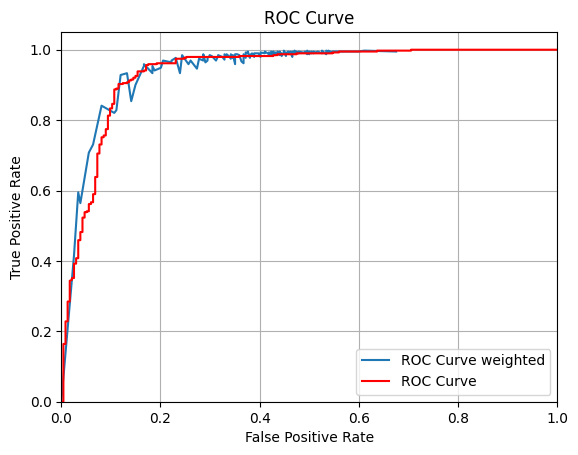

In [ ]:
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points] 

#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label="ROC Curve weighted")
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve", color='red')
#plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()

### Cost sensitive ROC built using the decision rule
* Calculate/assume the marginal probability P[Y=1]. Lets keep it 0.5, as varying the w will sweep across all the threshold values from 0 to 1.This will give exactly the conventional ROC curve
* Lets change the P[Y=1] value based on the actual probability in the training set
* Calculate the threshold

In [ ]:
from sklearn.metrics import confusion_matrix
# number of samples of each class in training set
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)

#p = (postive_count) / (postive_count + negative_count)
#p = 0.5
class_ratio = np.linspace(0.001, 0.999, 10, endpoint=True)


fpr_weighted_fast = []
tpr_weighted_fast = []

#p = 0.5  # marginal probability of positive class

model_orig.eval()
wgt = np.linspace(0.001, 0.999, 10, endpoint=True)

# Wrap the outer loop with tqdm for the progress bar
for p in tqdm(class_ratio, desc="[Calculating FPR/TPR]", leave=True):
    for w in wgt:
        all_predictions = []
        all_labels = []
        #b = w/(1 - w)
        #p = (b * postive_count) / (b * postive_count + negative_count)
        pos_weight = w
        # Calculate the decision rule
        dec_rule = p * (1 - w) / (w * (1 - p) + p * (1 - w))
        with torch.no_grad():
            for inputs, labels in tqdm(
                test_loader, desc=f"[Test - pos_weight={pos_weight:.3f}]", leave=False
            ):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model_orig(inputs)
                predictions = (torch.sigmoid(outputs) > dec_rule).float()  # Binary predictions
                all_predictions.extend(predictions.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_predictions)
        tn, fp, fn, tp = cm.ravel()
        test_accuracy = (tp + tn) / (tp + tn + fp + fn)
        test_precision = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
        test_recall = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
        test_f1 = (
            2 * (test_precision * test_recall) / (test_precision + test_recall)
            if (test_precision + test_recall) > 0
            else float("nan")
        )
        # print(f"Test Accuracy: {test_accuracy:.4f}")
        # print(f"Test Precision: {test_precision:.4f}")
        # print(f"Test Recall: {test_recall:.4f}")
        # print(f"Test F1-Score: {test_f1:.4f}")

        # Calculate FPR and TPR
        fpr = fp / (fp + tn) if (fp + tn) > 0 else float("nan")
        tpr = tp / (tp + fn) if (tp + fn) > 0 else float("nan")

        fpr_weighted_fast.append(fpr)
        tpr_weighted_fast.append(tpr)


[Calculating FPR/TPR]: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


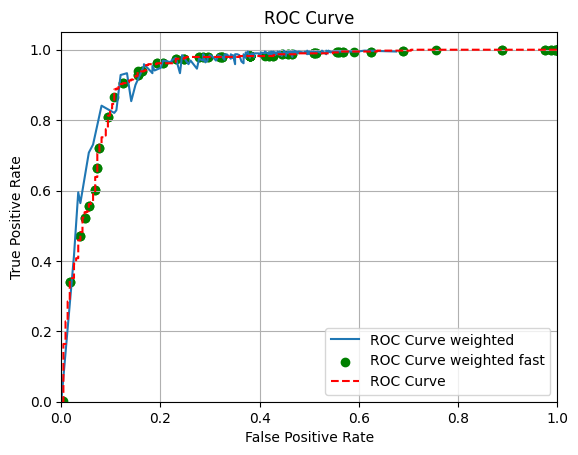

In [ ]:
roc_points = sorted(zip(fpr_weighted_fast, tpr_weighted_fast))
fpr_weighted_sorted_fast = [p[0] for p in roc_points]
tpr_weighted_sorted_fast = [p[1] for p in roc_points] 

#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label="ROC Curve weighted")
plt.scatter(fpr_weighted_sorted_fast, tpr_weighted_sorted_fast, label="ROC Curve weighted fast", color='green')
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve", color='red', linestyle='dashed')
#plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()